The "Marketplace" company is launching an e-commerce marketplace where sellers offer items by posting a photo and description. Currently the categorization of the small number of products is done manually. The e-commerce site aims to expand and significantly increase the number of products, and manual categorization would be a long and unreliable step. To facilitate the posting of new articles and the search for products, it becomes necessary to automate this task. This categorization will be done from the descriptions and images of the products.

La mission est de réaliser une première étude de faisabilité d'un moteur de classification d'articles basé sur une image et une description pour l'automatisation de l'attribution de la catégorie de l'article.

### **Text Analysis**

https://towardsdatascience.com/text-normalization-for-natural-language-processing-nlp-70a314bfa646

In [3]:
# Data Structures
import numpy as np
import pandas as pd

#for visualisation
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from wordcloud import WordCloud, STOPWORDS 

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


# Corpus Processing
import nltk
nltk.download('stopwords')
import string
import re

from nltk.tokenize import word_tokenize
from nltk.tokenize import  RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from nltk import SnowballStemmer,PorterStemmer


from sklearn.cluster import KMeans
from sklearn.manifold import TSNE


from sklearn.decomposition            import TruncatedSVD
from sklearn.decomposition            import NMF
from sklearn.decomposition            import LatentDirichletAllocation
from sklearn.decomposition            import PCA


from sklearn.metrics import confusion_matrix
from sklearn.metrics import homogeneity_score
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_rand_score

from sklearn.feature_extraction.text  import TfidfVectorizer


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
#Download databases
data_con= pd.read_csv('/content/drive/MyDrive/p6/flipkart_com-ecommerce_sample_1050.csv',sep=',')
data_con.head(3)

uniq_id            crawl_timestamp  \
0  55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1  7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   
2  64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000   

                                         product_url  \
0  http://www.flipkart.com/elegance-polyester-mul...   
1  http://www.flipkart.com/sathiyas-cotton-bath-t...   
2  http://www.flipkart.com/eurospa-cotton-terry-f...   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   

                               product_category_tree               pid  \
0  ["Home Furnishing >> Curtains & Accessories >>...  CRNEG7BKMFFYHQ8Z   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEGFZHGBXPHZUH   
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEG6SHXTDB2A2Y   

   retail_price  discounted_price                                 image  \
0        1899.0             899.0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1         600.0             449.0  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2           NaN               NaN  64d5d4a258243731dc7bbb1eef49ad74.jpg   

   is_FK_Advantage_product                                        description  \
0                    False  Key Features of Elegance Polyester Multicolor ...   
1                    False  Specifications of Sathiyas Cotton Bath Towel (...   
2                    False  Key Features of Eurospa Cotton Terry Face Towe...   

        product_rating       overall_rating     brand  \
0  No rating available  No rating available  Elegance   
1  No rating available  No rating available  Sathiyas   
2  No rating available  No rating available   Eurospa   

                              product_specifications  
0  {"product_specification"=>[{"key"=>"Brand", "v...  
1  {"product_specification"=>[{"key"=>"Machine Wa...  
2  {"product_specification"=>[{"key"=>"Material",...

In [6]:
del data_con['is_FK_Advantage_product']  # Boolean
del data_con['crawl_timestamp']

In [7]:
data_con['uniq_id'].duplicated().sum()

0

In [8]:
data_con.shape

(1050, 13)

In [9]:
data_con.isnull().sum()

uniq_id                     0
product_url                 0
product_name                0
product_category_tree       0
pid                         0
retail_price                1
discounted_price            1
image                       0
description                 0
product_rating              0
overall_rating              0
brand                     338
product_specifications      1
dtype: int64

 ***We have some missing values!!***

---



### **Missing values and imputation**

In [10]:
import missingno as msno

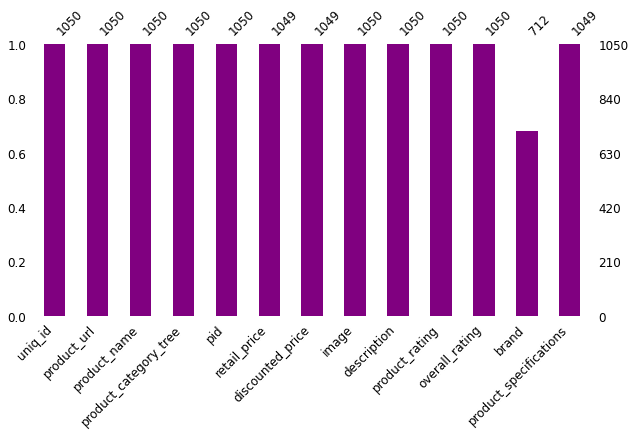

In [11]:
msno.bar(data_con,  figsize=(10,5), fontsize=12, color="purple")

there is missing value for 'retail_price' , 'discounted_price' , 'brand' & 'product_specifications'

**Imputation**

In [12]:
data_con['retail_price'].fillna((data_con['retail_price'].median()), inplace=True)
data_con['discounted_price'].fillna((data_con['discounted_price'].median()), inplace=True)

In [13]:
data_con['brand'].fillna((data_con['brand'].mode()[0]), inplace=True)
data_con['product_specifications'].fillna((data_con['product_specifications'].mode()[0]), inplace=True)

In [14]:
data_con.isnull().sum()

uniq_id                   0
product_url               0
product_name              0
product_category_tree     0
pid                       0
retail_price              0
discounted_price          0
image                     0
description               0
product_rating            0
overall_rating            0
brand                     0
product_specifications    0
dtype: int64

### **Data Exploration**

In [15]:
data = data_con.filter(items=['uniq_id','image', 'product_name', 'product_category_tree', 'description'])

## **Cleaning dataset & visualisation**

### Product Name

In [16]:
data['product_name'].unique()

array(['Elegance Polyester Multicolor Abstract Eyelet Door Curtain',
       'Sathiyas Cotton Bath Towel',
       'Eurospa Cotton Terry Face Towel Set', ...,
       'Uberlyfe Extra Large Pigmented Polyvinyl Films (Imported) Sticker',
       'Wallmantra Medium Vinyl Sticker Sticker',
       'Uberlyfe Large Vinyl Sticker'], dtype=object)

In [17]:
data['product_category_tree'].sample(5)

244    ["Kitchen & Dining >> Cookware >> Pots & Pans ...
46     ["Kitchen & Dining >> Coffee Mugs >> AKUP Coff...
376    ["Beauty and Personal Care >> Fragrances >> De...
884          ["Home Furnishing >> Bath Linen >> Towels"]
729    ["Home Decor & Festive Needs >> Decorative Lig...
Name: product_category_tree, dtype: object

In [18]:
data['description'].sample(5)

649    Key Features of KLOCX Analog Wall Clock Black ...
300    Buy Elephant 9.84 inch Lid for Rs.450 online. ...
764    Chappin & Nellson CNL-50-White-RG Analog Watch...
793    Ollington St. Collection Baby Reusable Diaper ...
607    Key Features of Aapno Rajasthan Lovely Jewelle...
Name: description, dtype: object

**Cleaning 'product_category_tree' column**

In [19]:
data['product_category_tree'][1]

'["Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Sathiyas Baby Bath Towels >> Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Y..."]'

In [20]:
data['category']=data['product_category_tree'].str.split(
    pat=">>",expand=True)[0]
data["category"] = data["category"].str.replace('[', "")
data["category"] = data["category"].str.replace('"', "")
data["category"] = data["category"].str.replace(' ', "")

catg  = {'HomeFurnishing':'Home',
         'HomeDecor&FestiveNeeds':'Decor',
         'Watches':'Watches',
         'BabyCare':'Baby',
         'BeautyandPersonalCare':'Beauty',
         'Computers':'Computers',
         'Kitchen&Dining':'Kitchen'}
data['category'] =[catg[i] for i in data['category']]
cluster  = {'Baby':0,
           'Decor':1,
           'Computers':2,
           'Watches':3,
           'Kitchen':4,
           'Home':5,
           'Beauty':6}

label_category = data['category'].map(cluster)
data["label_category"] = label_category

In [21]:
data['category_1']=data['product_category_tree'].str.split(
    pat=">>",expand=True)[1]
data["category_1"] = data["category_1"].str.replace('[', "")
data["category_1"] = data["category_1"].str.replace('"', "")
data["category_1"] = data["category_1"].str.replace(' ', "")

In [22]:
data['category'].value_counts()

Baby         150
Decor        150
Kitchen      150
Home         150
Beauty       150
Watches      150
Computers    150
Name: category, dtype: int64

In [23]:
data.describe(include='all').T

count unique  \
uniq_id                1050   1050   
image                  1050   1050   
product_name           1050   1050   
product_category_tree  1050    642   
description            1050   1050   
category               1050      7   
label_category         1050    NaN   
category_1             1050     63   

                                                                     top freq  \
uniq_id                                 4b500e244f11a45f5171bd3665413044    1   
image                               9b00cab981ab825158c05c9e54b866d4.jpg    1   
product_name           Curren Nx Blue Dial Stiched Strap Analog Watch...    1   
product_category_tree  ["Home Furnishing >> Bed Linen >> Blankets, Qu...   56   
description            Buy Shop Rajasthan Abstract Single Dohar Multi...    1   
category                                                            Baby  150   
label_category                                                       NaN  NaN   
category_1                                                  WristWatches  149   

                      mean      std  min  25%  50%  75%  max  
uniq_id                NaN      NaN  NaN  NaN  NaN  NaN  NaN  
image                  NaN      NaN  NaN  NaN  NaN  NaN  NaN  
product_name           NaN      NaN  NaN  NaN  NaN  NaN  NaN  
product_category_tree  NaN      NaN  NaN  NaN  NaN  NaN  NaN  
description            NaN      NaN  NaN  NaN  NaN  NaN  NaN  
category               NaN      NaN  NaN  NaN  NaN  NaN  NaN  
label_category           3  2.00095    0    1    3    5    6  
category_1             NaN      NaN  NaN  NaN  NaN  NaN  NaN

In [24]:
data.drop('product_category_tree',inplace=True, axis=1)

In [25]:
data.head()

uniq_id                                 image  \
0  55b85ea15a1536d46b7190ad6fff8ce7  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1  7b72c92c2f6c40268628ec5f14c6d590  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2  64d5d4a258243731dc7bbb1eef49ad74  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3  d4684dcdc759dd9cdf41504698d737d8  d4684dcdc759dd9cdf41504698d737d8.jpg   
4  6325b6870c54cd47be6ebfbffa620ec7  6325b6870c54cd47be6ebfbffa620ec7.jpg   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  Jaipur Print Cotton Floral King sized Double B...   

                                         description category  label_category  \
0  Key Features of Elegance Polyester Multicolor ...     Home               5   
1  Specifications of Sathiyas Cotton Bath Towel (...     Baby               0   
2  Key Features of Eurospa Cotton Terry Face Towe...     Baby               0   
3  Key Features of SANTOSH ROYAL FASHION Cotton P...     Home               5   
4  Key Features of Jaipur Print Cotton Floral Kin...     Home               5   

             category_1  
0  Curtains&Accessories  
1         BabyBath&Skin  
2         BabyBath&Skin  
3              BedLinen  
4              BedLinen

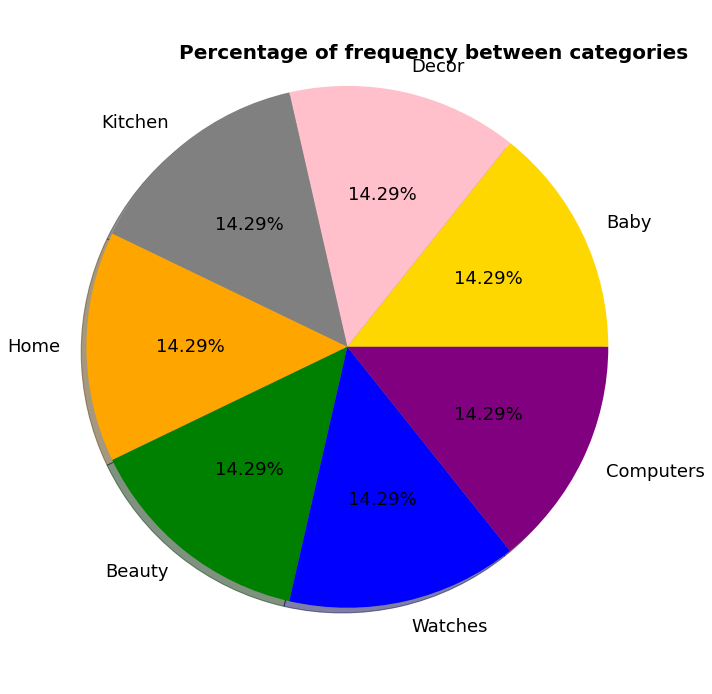

In [26]:
values = data['category'].value_counts()
labels = data['category'].value_counts().index
colors = ['gold', 'pink', 'grey', 'orange', 'green', 'blue', 'purple']
explode = (0, 0, 0, 0, 0, 0, 0)

# Plot
plt.figure(figsize=(10, 10))
plt.pie(values, explode=explode, labels=labels, colors=colors,
        autopct='%.2f%%', shadow=True, textprops={'fontsize': 18})

ttl = plt.title( "Percentage of frequency between categories",  fontweight = 'bold' ,fontsize=20,pad=50)

ttl.set_position([0.65, 0.85])
plt.axis('equal')
plt.tight_layout()

In [27]:
pd.set_option('display.max_row',62)
data['category_1'].value_counts().head(20)
#Nous avons 62 catégories 
#c'est plus détaille que les categories de la colonne cat_lvl1

WristWatches              149
LaptopAccessories          87
InfantWear                 84
CoffeeMugs                 74
Showpieces                 71
Fragrances                 65
BedLinen                   65
NetworkComponents          49
Cookware                   27
TableDecor&Handicrafts     27
CombosandKits              24
WallDecor&Clocks           22
BathLinen                  21
Curtains&Accessories       19
Makeup                     18
BodyandSkinCare            15
Baby&KidsGifts             15
BabyBedding                15
BabyBath&Skin              14
KitchenTools               14
Name: category_1, dtype: int64

### **Text Preprocessing**

* remove punctional
* keep only alphabetic characters
* remove stopwords and isolated letters
* put all words in lowercase
* lemmatization
* keep only the canonical forms of words



In [28]:
data['description'].head()

0    Key Features of Elegance Polyester Multicolor ...
1    Specifications of Sathiyas Cotton Bath Towel (...
2    Key Features of Eurospa Cotton Terry Face Towe...
3    Key Features of SANTOSH ROYAL FASHION Cotton P...
4    Key Features of Jaipur Print Cotton Floral Kin...
Name: description, dtype: object

In [29]:
data['description'].sample(5)

32     D'Signer 681GM_WHT Analog Watch  - For Men, Bo...
971    Key Features of Sparklings Cotton Geometric Do...
170    Prithish Eye Abstract Painting Ceramic Mug (33...
412    Flipkart.com: Buy Denver RO,Spring Combo Set o...
810    Buy Oxyglow Fruit Massage Cream With Vitamin-E...
Name: description, dtype: object

In [30]:
len(data['description'])

1050

**Function for the number of words**

In [31]:
def word_size(base,columns):
  corpus=base[columns]

  words_dico=dict()
  import re
  #importation regular expressions

  expr = re.compile("\W+",re.U) # Regular expression of segmentation on spaces
  for text in corpus: # For each comment in the corpus
    text = str(text)
    text = expr.split(text)
    for word in set(text): # Retrieving each new word
      if word not in words_dico:
        words_dico[word]=1
      else: 
          # For each word already listed: add 1 if it is found
            words_dico[word]=words_dico[word]+1

  return len(words_dico)

In [32]:
size=word_size(data,'description')
print(size)


7671


In [33]:
size=word_size(data,'product_name')
print(size)

2531



$\color{orange}{\text{1- Lower word}}$







In [34]:
data["description_clean"] = data["description"].apply(lambda x: x.lower())
data["name_clean"] = data["product_name"].apply(lambda x: x.lower())

display(data.sample(2))

uniq_id                                 image  \
361  dd0b73d97cea6cc71d263a77fa7982be  dd0b73d97cea6cc71d263a77fa7982be.jpg   
739  52877a6306aef18af67ab54c8233c931  52877a6306aef18af67ab54c8233c931.jpg   

                                  product_name  \
361  Aero Care La Royal Orange & Ice Combo Set   
739                        Buyer's Beach BB349   

                                           description category  \
361  Flipkart.com: Buy Aero Care La Royal Orange & ...   Beauty   
739  Buyer's Beach BB349 (Brown) Price: Rs. 449 Sty...  Kitchen   

     label_category           category_1  \
361               6           Fragrances   
739               4  Dinnerware&Crockery   

                                     description_clean  \
361  flipkart.com: buy aero care la royal orange & ...   
739  buyer's beach bb349 (brown) price: rs. 449 sty...   

                                    name_clean  
361  aero care la royal orange & ice combo set  
739                        buyer's beach bb349

In [35]:
size=word_size(data,'description_clean')
print(size)

6086


In [36]:
size=word_size(data,'name_clean')
print(size)

2387


$\color{orange}{\text{2- Contraction}}$


we will or we shouldnt've -> we should not have.

In [37]:
!pip install contractions

     |████████████████████████████████| 284 kB 7.0 MB/s 
     |████████████████████████████████| 321 kB 57.9 MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85437 sha256=0373873c12de05381cbe14fbd1d61cb0cc085cc2dff4102b5c0da6df51ecfb7c
  Stored in directory: /root/.cache/pip/wheels/25/19/a6/8f363d9939162782bb8439d886469756271abc01f76fbd790f
Successfully built pyahocorasick


In [38]:
import contractions
data["description_clean"] = data["description"].apply(lambda x: contractions.fix(x))
data["name_clean"] = data["product_name"].apply(lambda x: contractions.fix(x))

display(data.sample(2))

uniq_id                                 image  \
602  c91f9dc1fdd8b4d60c6b2a2b607e3e8f  c91f9dc1fdd8b4d60c6b2a2b607e3e8f.jpg   
975  4b500e244f11a45f5171bd3665413044  4b500e244f11a45f5171bd3665413044.jpg   

                                          product_name  \
602  Curren Nx Blue Dial Stiched Strap Analog Watch...   
975  Jacadi paris Baby Boy's Striped Casual Blue Shirt   

                                           description category  \
602  Key Features of Curren Nx Blue Dial Stiched St...  Watches   
975  Key Features of Jacadi paris Baby Boy's Stripe...     Baby   

     label_category    category_1  \
602               3  WristWatches   
975               0    InfantWear   

                                     description_clean  \
602  Key Features of Curren Nx Blue Dial Stiched St...   
975  Key Features of Jacadi paris Baby Boy's Stripe...   

                                            name_clean  
602  Curren Nx Blue Dial Stiched Strap Analog Watch...  
975  Jacadi paris Baby Boy's Striped Casual Blue Shirt

In [39]:
size=word_size(data,'description_clean')
print(size)

7660


In [40]:
size=word_size(data,'name_clean')
print(size)

2531


$\color{orange}{\text{3- Punctual words}}$



* To add space after all punctual words

In [41]:
oldstr=data['description_clean'][0]
re.sub(r'\.([a-zA-Z])', r'. \1', oldstr)
re.sub(r'\,([a-zA-Z])', r', \1', oldstr)

'Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain, Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light in your room so that yo

In [42]:
def add_space(oldstr):
  oldstr=re.sub(r'\.([a-zA-Z])', r'. \1', oldstr) # Add space after . & ,
  oldstr=re.sub(r'\,([a-zA-Z])', r', \1', oldstr)
  return oldstr

In [43]:
data["description_clean"] = data["description_clean"].apply(lambda x: add_space(x))

In [44]:
data['description_clean'][0]

'Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain, Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors. This curtain is made from 100% high quality polyester fabric. It features an eyelet style stitch with Metal Ring. It makes the room environment romantic and loving. This curtain is ant- wrinkle and anti shrinkage and have elegant apparance. Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light in your room so th

Removing punctual words & numbers ...

In [45]:

def remove_Noise(text):
    """
        Remove URLs from a sample string
    """
    text=text.translate(str.maketrans(' ', ' ', string.punctuation)) #remove ponctuation,
    text = text.rstrip('\n')              # Removes line breaks
    text=re.sub(r"https?://\S+|www\.\S+", "  ", text)
    #html = re.compile(r"<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});")
    #text=re.sub(html, "", text)
    text =re.sub(r'[^\x00-\x7f]',r' ', text) #Remove non-ASCII characters
    text=re.sub('\W_',' ', text)        # removes specials characters and leaves only words
    text = re.sub("\S*\d\S*","  ", text)   # removes numbers and words concatenated with numbers IE h4ck3r. Removes road names such as BR-381.
    text = re.sub("\S*@\S*\s?","  ", text) # removes emails and mentions (words with @)
    return text

In [46]:
data["description_clean"] = data["description_clean"].apply(lambda x: remove_Noise(x))
data["name_clean"] = data["name_clean"].apply(lambda x: remove_Noise(x))

display(data.sample(2))

uniq_id                                 image  \
4    6325b6870c54cd47be6ebfbffa620ec7  6325b6870c54cd47be6ebfbffa620ec7.jpg   
649  7cf36a3f1f2bd785954cc876a941da40  7cf36a3f1f2bd785954cc876a941da40.jpg   

                                          product_name  \
4    Jaipur Print Cotton Floral King sized Double B...   
649                            KLOCX Analog Wall Clock   

                                           description category  \
4    Key Features of Jaipur Print Cotton Floral Kin...     Home   
649  Key Features of KLOCX Analog Wall Clock Black ...    Decor   

     label_category        category_1  \
4                 5          BedLinen   
649               1  WallDecor&Clocks   

                                     description_clean  \
4    Key Features of Jaipur Print Cotton Floral Kin...   
649  Key Features of KLOCX Analog Wall Clock Black ...   

                                            name_clean  
4    Jaipur Print Cotton Floral King sized Double B...  
649                            KLOCX Analog Wall Clock

In [47]:
#test
idex=0
text=data.description[idex]
print('#text originale#:',text)
text_modifier=data['description_clean'][idex]
print('#text modifier#  :',text_modifier)

#text originale#: Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light in your

In [48]:
#test
idex=450
text=data.description[idex]
print('#text originale#:',text)
text_modifier=data['description_clean'][idex]
print('#text modifier#  :',text_modifier)

#text originale#: Specifications of Upside Down Sleeveless Applique Baby Girl's, Baby Boy's Jacket General Details Ideal For Baby Girl's, Baby Boy's Pattern Applique Jacket Details Fabric Poly Cotton Reversible No Hooded No Closure Buttons Sleeve Sleeveless Lining Cotton Fabric Care Dont Wash With Other Garments, Hand Wash With Mild Detergent,Dont Tumble Dry, Dry In Shade. Additional Details Style Code LIGHT PINK SMILEY FACE JACKET Other Details Sleeveless In the Box 1 Jacket
#text modifier#  : Specifications of Upside Down Sleeveless Applique Baby Girls Baby Boys Jacket General Details Ideal For Baby Girls Baby Boys Pattern Applique Jacket Details Fabric Poly Cotton Reversible No Hooded No Closure Buttons Sleeve Sleeveless Lining Cotton Fabric Care do not Wash With Other Garments Hand Wash With Mild Detergent do not Tumble Dry Dry In Shade Additional Details Style Code LIGHT PINK SMILEY FACE JACKET Other Details Sleeveless In the Box    Jacket


In [49]:
size=word_size(data,'description_clean')
print(size)

6613


In [50]:
size=word_size(data,'name_clean')
print(size)

2010


In [51]:
def wordcloud(corpus):
  corpus_wordcloud = WordCloud().generate(corpus)
  plt.imshow(corpus_wordcloud)
  plt.axis('off')
  plt.show()

Texte original   Nombre de tokens: 67
--------------
Specifications of Sathiyas Cotton Bath Towel    Bath Towel Red Yellow Blue Bath Towel Features Machine Washable Yes Material Cotton Design Self Design General Brand Sathiyas Type Bath Towel GSM    Model Name Sathiyas cotton bath towel Ideal For Men Women Boys Girls Model ID    Color Red Yellow Blue Size Mediam Dimensions Length    inch Width    inch In the Box Number of Contents in Sales Package    Sales Package    Bath Towel


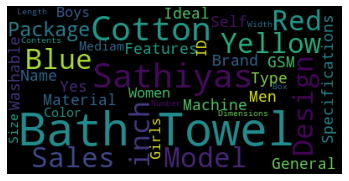

In [52]:
# Paramètre
p_id = 1
content = data.loc[p_id,'description_clean']

prec, tokens_nb = ' ', 0
for char in content:
  tokens_nb += int(prec == ' ' and char != ' ')
  prec = char

process_step = 'Texte original'
print(process_step,'  Nombre de tokens:',tokens_nb)
print(len(process_step)*'-')
print(content)

wordcloud(content)

$\color{orange}{\text{4- Tokenize}}$


Tokenization is a way of separating a piece of text into smaller units called tokens. Here, tokens can be either words, characters, or subwords. Hence, tokenization can be broadly classified into 3 types – word, character, and subword (n-gram characters) tokenization.


1.   Character tokens: s-m-a-r-t-e-r
2.   Subword tokens: smart-er
3.   Word tokenization:  Never-give-up

https://www.analyticsvidhya.com/blog/2020/05/what-is-tokenization-nlp/

https://www.analyticsvidhya.com/blog/2019/07/how-get-started-nlp-6-unique-ways-perform-tokenization/

In [53]:
def tokenization(text):
  nltk_tokens = nltk.word_tokenize(text)
  return nltk_tokens

In [54]:
# Tokenizing  texts.
from nltk.tokenize import word_tokenize
nltk.download('punkt')

data['description_tokenized'] = data["description_clean"].apply(lambda x: tokenization(x))
data['name_tokenized'] = data["name_clean"].apply(lambda x: tokenization(x))

display(data.sample(2))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


uniq_id                                 image  \
613  4e03d4e81e6a876f512536f6a57c053e  4e03d4e81e6a876f512536f6a57c053e.jpg   
324  a43fbae655e5d13215b9dd65339fa9d4  a43fbae655e5d13215b9dd65339fa9d4.jpg   

                                        product_name  \
613              Piyo Piyo Four Stage Waterproof Bib   
324  Huawei WS331c -300 Mbps Wireless Range Extender   

                                           description   category  \
613  Specifications of Piyo Piyo Four Stage Waterpr...       Baby   
324  Buy Huawei WS331c -300 Mbps Wireless Range Ext...  Computers   

     label_category         category_1  \
613               0    Feeding&Nursing   
324               2  NetworkComponents   

                                     description_clean  \
613  Specifications of Piyo Piyo Four Stage Waterpr...   
324  Buy Huawei       Mbps Wireless Range Extender ...   

                                    name_clean  \
613        Piyo Piyo Four Stage Waterproof Bib   
324  Huawei       Mbps Wireless Range Extender   

                                 description_tokenized  \
613  [Specifications, of, Piyo, Piyo, Four, Stage, ...   
324  [Buy, Huawei, Mbps, Wireless, Range, Extender,...   

                                 name_tokenized  
613  [Piyo, Piyo, Four, Stage, Waterproof, Bib]  
324   [Huawei, Mbps, Wireless, Range, Extender]

In [55]:
#test
text=data.description[idex]
print('#text originale#:',text)
text_modifier=data['description_clean'][idex]
print('#text modifier#  :',text_modifier)
text_tokenized=data['description_tokenized'][idex]
print('#text tokenized#  :',text_tokenized)

#text originale#: Specifications of Upside Down Sleeveless Applique Baby Girl's, Baby Boy's Jacket General Details Ideal For Baby Girl's, Baby Boy's Pattern Applique Jacket Details Fabric Poly Cotton Reversible No Hooded No Closure Buttons Sleeve Sleeveless Lining Cotton Fabric Care Dont Wash With Other Garments, Hand Wash With Mild Detergent,Dont Tumble Dry, Dry In Shade. Additional Details Style Code LIGHT PINK SMILEY FACE JACKET Other Details Sleeveless In the Box 1 Jacket
#text modifier#  : Specifications of Upside Down Sleeveless Applique Baby Girls Baby Boys Jacket General Details Ideal For Baby Girls Baby Boys Pattern Applique Jacket Details Fabric Poly Cotton Reversible No Hooded No Closure Buttons Sleeve Sleeveless Lining Cotton Fabric Care do not Wash With Other Garments Hand Wash With Mild Detergent do not Tumble Dry Dry In Shade Additional Details Style Code LIGHT PINK SMILEY FACE JACKET Other Details Sleeveless In the Box    Jacket
#text tokenized#  : ['Specifications', 'o

In [56]:
size_f_Td=word_size(data,'description_tokenized')
print(size_f_Td)

6612


In [57]:
size_f_Tn=word_size(data,'name_tokenized')
print(size_f_Tn)

2010


Tokenisation   Nombre de tokens: 67
------------
Specifications of Sathiyas Cotton Bath Towel Bath Towel Red Yellow Blue Bath Towel Features Machine Washable Yes Material Cotton Design Self Design General Brand Sathiyas Type Bath Towel GSM Model Name Sathiyas cotton bath towel Ideal For Men Women Boys Girls Model ID Color Red Yellow Blue Size Mediam Dimensions Length inch Width inch In the Box Number of Contents in Sales Package Sales Package Bath Towel


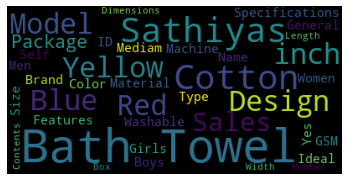

In [58]:
process_step = 'Tokenisation'
print(process_step,'  Nombre de tokens:',len(data.loc[p_id,'description_tokenized']))
print(len(process_step)*'-')

content = data['description_tokenized'].apply(lambda x: ' '.join(x)).iloc[p_id]
print(content)

wordcloud(content)

In [59]:
tokens_list= []

# Avec normalisation
tokenizer = nltk.RegexpTokenizer(r'\w+')
for i in range(0,len(data)):        
    tokens_list.append(tokenizer.tokenize(data.iloc[i,7]))
    
data['description_tok_norm'] = tokens_list

In [60]:
tokens_list = []

# Avec normalisation
tokenizer = nltk.RegexpTokenizer(r'\w+')
for i in range(0,len(data)):        
    tokens_list.append(tokenizer.tokenize(data.iloc[i,8]))

data['name_tok_norm'] = tokens_list

In [61]:
data.head(2)

uniq_id                                 image  \
0  55b85ea15a1536d46b7190ad6fff8ce7  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1  7b72c92c2f6c40268628ec5f14c6d590  7b72c92c2f6c40268628ec5f14c6d590.jpg   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   

                                         description category  label_category  \
0  Key Features of Elegance Polyester Multicolor ...     Home               5   
1  Specifications of Sathiyas Cotton Bath Towel (...     Baby               0   

             category_1                                  description_clean  \
0  Curtains&Accessories  Key Features of Elegance Polyester Multicolor ...   
1         BabyBath&Skin  Specifications of Sathiyas Cotton Bath Towel  ...   

                                          name_clean  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   

                               description_tokenized  \
0  [Key, Features, of, Elegance, Polyester, Multi...   
1  [Specifications, of, Sathiyas, Cotton, Bath, T...   

                                      name_tokenized  \
0  [Elegance, Polyester, Multicolor, Abstract, Ey...   
1                    [Sathiyas, Cotton, Bath, Towel]   

                                description_tok_norm  \
0  [Key, Features, of, Elegance, Polyester, Multi...   
1  [Specifications, of, Sathiyas, Cotton, Bath, T...   

                                       name_tok_norm  
0  [Elegance, Polyester, Multicolor, Abstract, Ey...  
1                    [Sathiyas, Cotton, Bath, Towel]

In [62]:
size_f3=word_size(data,'description_tok_norm')
print(size_f3)

6613


In [63]:
size_f3=word_size(data,'name_tok_norm')
print(size_f3)

2010


In [64]:
#test
text=data.description[idex]
print('#text originale#:',text)
text_tokenized=data['description_tokenized'][idex]
print('#text tokenized#  :',text_tokenized)
text_modifier=data['description_tok_norm'][idex]
print('#text tok_normalized#  :',text_modifier)

#text originale#: Specifications of Upside Down Sleeveless Applique Baby Girl's, Baby Boy's Jacket General Details Ideal For Baby Girl's, Baby Boy's Pattern Applique Jacket Details Fabric Poly Cotton Reversible No Hooded No Closure Buttons Sleeve Sleeveless Lining Cotton Fabric Care Dont Wash With Other Garments, Hand Wash With Mild Detergent,Dont Tumble Dry, Dry In Shade. Additional Details Style Code LIGHT PINK SMILEY FACE JACKET Other Details Sleeveless In the Box 1 Jacket
#text tokenized#  : ['Specifications', 'of', 'Upside', 'Down', 'Sleeveless', 'Applique', 'Baby', 'Girls', 'Baby', 'Boys', 'Jacket', 'General', 'Details', 'Ideal', 'For', 'Baby', 'Girls', 'Baby', 'Boys', 'Pattern', 'Applique', 'Jacket', 'Details', 'Fabric', 'Poly', 'Cotton', 'Reversible', 'No', 'Hooded', 'No', 'Closure', 'Buttons', 'Sleeve', 'Sleeveless', 'Lining', 'Cotton', 'Fabric', 'Care', 'do', 'not', 'Wash', 'With', 'Other', 'Garments', 'Hand', 'Wash', 'With', 'Mild', 'Detergent', 'do', 'not', 'Tumble', 'Dry',

Tokenisation   Nombre de tokens: 67
------------
Specifications of Sathiyas Cotton Bath Towel Bath Towel Red Yellow Blue Bath Towel Features Machine Washable Yes Material Cotton Design Self Design General Brand Sathiyas Type Bath Towel GSM Model Name Sathiyas cotton bath towel Ideal For Men Women Boys Girls Model ID Color Red Yellow Blue Size Mediam Dimensions Length inch Width inch In the Box Number of Contents in Sales Package Sales Package Bath Towel


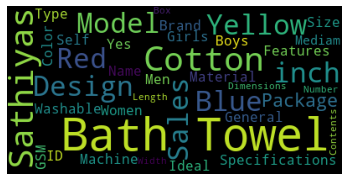

In [65]:
process_step = 'Tokenisation'
print(process_step,'  Nombre de tokens:',len(data.loc[p_id,'description_tok_norm']))
print(len(process_step)*'-')

content = data['description_tok_norm'].apply(lambda x: ' '.join(x)).iloc[p_id]
print(content)

wordcloud(content)

In [66]:
def clean_2(data,description_clean):
    
    data[description_clean] = data[description_clean].str.lower()

    data[description_clean] = data[description_clean].str.replace('\'','')
    data[description_clean] = data[description_clean].str.replace('\`','')    
    data[description_clean] = data[description_clean].str.replace('\"','')
    data[description_clean] = data[description_clean].str.replace('[','')
    data[description_clean] = data[description_clean].str.replace(']','')    
    data[description_clean] = data[description_clean].str.replace('(','')
    data[description_clean] = data[description_clean].str.replace(')','')
    data[description_clean] = data[description_clean].str.replace('{','')
    data[description_clean] = data[description_clean].str.replace('}','')

    data[description_clean] = data[description_clean].str.replace('@',' ')
    data[description_clean] = data[description_clean].str.replace('?',' ')
    data[description_clean] = data[description_clean].str.replace('!',' ')

    data[description_clean] = data[description_clean].str.replace(';',' ')
    data[description_clean] = data[description_clean].str.replace(',',' ')
    data[description_clean] = data[description_clean].str.replace('.',' ')    
    data[description_clean] = data[description_clean].str.replace(':',' ')

    data[description_clean] = data[description_clean].str.replace('&',' ')
    data[description_clean] = data[description_clean].str.replace('-',' ')
    data[description_clean] = data[description_clean].str.replace('/',' ')
    data[description_clean] = data[description_clean].str.replace('_',' ')
    data[description_clean] = data[description_clean].str.replace('±',' ')
    data[description_clean] = data[description_clean].str.replace('*',' ')
    data[description_clean] = data[description_clean].str.replace('%',' ')

    data[description_clean] = data[description_clean].str.replace('0',' ')
    data[description_clean] = data[description_clean].str.replace('1',' ')
    data[description_clean] = data[description_clean].str.replace('2',' ')
    data[description_clean] = data[description_clean].str.replace('3',' ')
    data[description_clean] = data[description_clean].str.replace('4',' ')
    data[description_clean] = data[description_clean].str.replace('5',' ')
    data[description_clean] = data[description_clean].str.replace('6',' ')
    data[description_clean] = data[description_clean].str.replace('7',' ')
    data[description_clean] = data[description_clean].str.replace('8',' ')
    data[description_clean] = data[description_clean].str.replace('9',' ') 
    
    data[description_clean] = data[description_clean].str.replace('aa',' ')
    data[description_clean] = data[description_clean].str.replace('aaa',' ')

    data[description_clean] = data[description_clean].str.replace('jumpsuit\r\n',' jumpsuit ')
    data[description_clean] = data[description_clean].str.replace('\r\n\t\t\t\t\r\n\t\t\thigh',' thigh ')
    data[description_clean] = data[description_clean].str.replace('quality\xa0aluminum','quality aluminum')    
    data[description_clean] = data[description_clean].str.replace('boys\r\n','boys')
    data[description_clean] = data[description_clean].str.replace('abstrcts','abstract')
    data[description_clean] = data[description_clean].str.replace('asvtwl','')
    data[description_clean] = data[description_clean].str.replace('\r\n\t\t\t\t\r\n\t\t\t',' ') 

    data[description_clean] = data[description_clean].str.replace('   ',' ') 
    data[description_clean] = data[description_clean].str.replace('  ',' ')    
 
    data[description_clean] = data[description_clean].astype('str')

In [67]:
data['description_clean_1'] = data['description_clean']

In [68]:
normalization_ = 1
if normalization_ == 1:
    # On normalise les valeurs de la variable temporaire 'content_clean'
    clean_2(data,'description_clean_1')

In [69]:
tokens_list = []

# Tokenisation avec normalisation
tokenizer = nltk.RegexpTokenizer(r'\w+')
for i in range(0,len(data)):
    # On tokenise les valeurs de la variale temporaire 'description_clean_1'
    # et on stocke les résultats dans une liste
    tokens_list.append(tokenizer.tokenize(data.loc[i,'description_clean_1']))
    
# On stocke les tokens dans une nouvelle variable 'content_tok_2'
data['description_clean_tok_2'] = tokens_list
# On supprime la variable temporaire 'content_clean'
#del data['description_clean_1']

data.head(2)

uniq_id                                 image  \
0  55b85ea15a1536d46b7190ad6fff8ce7  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1  7b72c92c2f6c40268628ec5f14c6d590  7b72c92c2f6c40268628ec5f14c6d590.jpg   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   

                                         description category  label_category  \
0  Key Features of Elegance Polyester Multicolor ...     Home               5   
1  Specifications of Sathiyas Cotton Bath Towel (...     Baby               0   

             category_1                                  description_clean  \
0  Curtains&Accessories  Key Features of Elegance Polyester Multicolor ...   
1         BabyBath&Skin  Specifications of Sathiyas Cotton Bath Towel  ...   

                                          name_clean  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   

                               description_tokenized  \
0  [Key, Features, of, Elegance, Polyester, Multi...   
1  [Specifications, of, Sathiyas, Cotton, Bath, T...   

                                      name_tokenized  \
0  [Elegance, Polyester, Multicolor, Abstract, Ey...   
1                    [Sathiyas, Cotton, Bath, Towel]   

                                description_tok_norm  \
0  [Key, Features, of, Elegance, Polyester, Multi...   
1  [Specifications, of, Sathiyas, Cotton, Bath, T...   

                                       name_tok_norm  \
0  [Elegance, Polyester, Multicolor, Abstract, Ey...   
1                    [Sathiyas, Cotton, Bath, Towel]   

                                 description_clean_1  \
0  key features of elegance polyester multicolor ...   
1  specifications of sathiyas cotton bath towel b...   

                             description_clean_tok_2  
0  [key, features, of, elegance, polyester, multi...  
1  [specifications, of, sathiyas, cotton, bath, t...

In [70]:
size_filtre4=word_size(data,'description_clean_tok_2')
print(size_filtre4)

5053


Tokenisation2   Nombre de tokens: 67
-------------
specifications of sathiyas cotton bath towel bath towel red yellow blue bath towel features machine washable yes material cotton design self design general brand sathiyas type bath towel gsm model name sathiyas cotton bath towel ideal for men women boys girls model id color red yellow blue size mediam dimensions length inch width inch in the box number of contents in sales package sales package bath towel


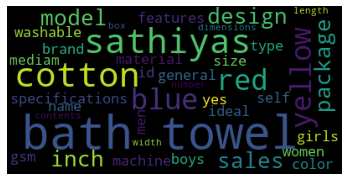

In [71]:
process_step = 'Tokenisation2'
print(process_step,'  Nombre de tokens:',len(data.loc[p_id,'description_clean_tok_2']))
print(len(process_step)*'-')

content = data['description_clean_tok_2'].apply(lambda x: ' '.join(x)).iloc[p_id]
print(content)

wordcloud(content)

$\color{orange}{\text{5- Stop words}}$

In [72]:
nltk.download("stopwords")
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [73]:

stopword=nltk.corpus.stopwords.words('english')

In [74]:
def remove_sw(text):
  text=[word for word in text if word not in stopword]
  return text

In [75]:
data['description_stopword']=data['description_clean_tok_2'].apply(lambda x : remove_sw(x))
data['name_stopword'] = data['name_tokenized'].apply(lambda x: remove_sw(x))
display(data.sample(3))

uniq_id                                 image  \
389  51dc964c7a47293ff0ed0c6912813722  51dc964c7a47293ff0ed0c6912813722.jpg   
504  cd089e2ef349a7f00dcdbf28965914f6  cd089e2ef349a7f00dcdbf28965914f6.jpg   
416  723e472f98180745980efe32411d30c6  723e472f98180745980efe32411d30c6.jpg   

                                          product_name  \
389                         Playboy New York Combo Set   
504  Lapguard HP Pavilion dv5-1008ax 6 Cell Laptop ...   
416                           Playboy Berlin Combo Set   

                                           description   category  \
389  Flipkart.com: Buy Playboy New York Combo Set o...     Beauty   
504  Buy Lapguard HP Pavilion dv5-1008ax 6 Cell Lap...  Computers   
416  Flipkart.com: Buy Playboy Berlin Combo Set onl...     Beauty   

     label_category         category_1  \
389               6         Fragrances   
504               2  LaptopAccessories   
416               6         Fragrances   

                                     description_clean  \
389  Flipkart com Buy Playboy New York Combo Set on...   
504  Buy Lapguard HP Pavilion       Cell Laptop Bat...   
416  Flipkart com Buy Playboy Berlin Combo Set onli...   

                                         name_clean  \
389                      Playboy New York Combo Set   
504  Lapguard HP Pavilion       Cell Laptop Battery   
416                        Playboy Berlin Combo Set   

                                 description_tokenized  \
389  [Flipkart, com, Buy, Playboy, New, York, Combo...   
504  [Buy, Lapguard, HP, Pavilion, Cell, Laptop, Ba...   
416  [Flipkart, com, Buy, Playboy, Berlin, Combo, S...   

                                      name_tokenized  \
389                 [Playboy, New, York, Combo, Set]   
504  [Lapguard, HP, Pavilion, Cell, Laptop, Battery]   
416                    [Playboy, Berlin, Combo, Set]   

                                  description_tok_norm  \
389  [Flipkart, com, Buy, Playboy, New, York, Combo...   
504  [Buy, Lapguard, HP, Pavilion, Cell, Laptop, Ba...   
416  [Flipkart, com, Buy, Playboy, Berlin, Combo, S...   

                                       name_tok_norm  \
389                 [Playboy, New, York, Combo, Set]   
504  [Lapguard, HP, Pavilion, Cell, Laptop, Battery]   
416                    [Playboy, Berlin, Combo, Set]   

                                   description_clean_1  \
389  flipkart com buy playboy new york combo set on...   
504  buy lapguard hp pavilion  cell laptop battery ...   
416  flipkart com buy playboy berlin combo set onli...   

                               description_clean_tok_2  \
389  [flipkart, com, buy, playboy, new, york, combo...   
504  [buy, lapguard, hp, pavilion, cell, laptop, ba...   
416  [flipkart, com, buy, playboy, berlin, combo, s...   

                                  description_stopword  \
389  [flipkart, com, buy, playboy, new, york, combo...   
504  [buy, lapguard, hp, pavilion, cell, laptop, ba...   
416  [flipkart, com, buy, playboy, berlin, combo, s...   

                                       name_stopword  
389                 [Playboy, New, York, Combo, Set]  
504  [Lapguard, HP, Pavilion, Cell, Laptop, Battery]  
416                    [Playboy, Berlin, Combo, Set]

In [76]:
#test
idex=0
text=data.description[idex]
print('#text originale#:',text)
text_modifier=data['description_stopword'][idex]
print('#text without stopwords#  :',text_modifier)

#text originale#: Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light in your

In [77]:
size_filtre4=word_size(data,'description_stopword')
print(size_filtre4)

4939


stopword   Nombre de stop word: 61
--------
specifications sathiyas cotton bath towel bath towel red yellow blue bath towel features machine washable yes material cotton design self design general brand sathiyas type bath towel gsm model name sathiyas cotton bath towel ideal men women boys girls model id color red yellow blue size mediam dimensions length inch width inch box number contents sales package sales package bath towel


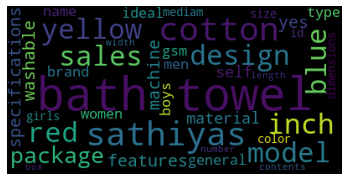

In [78]:
process_step = 'stopword'
print(process_step,'  Nombre de stop word:',len(data.loc[p_id,'description_stopword']))
print(len(process_step)*'-')

content = data['description_stopword'].apply(lambda x: ' '.join(x)).iloc[p_id]
print(content)

wordcloud(content)

$\color{orange}{\text{6- 2nd stop words}}$

Deleting the words which has just one letter

In [79]:
def rem_short_words(words_list, char_len = 2):
    word_len = [len(i) for i in words_list]
    index_keep = np.array(word_len) > char_len
    words_list_red = np.array(words_list)[index_keep]
    return(list(words_list_red))

In [80]:
from nltk.corpus import stopwords
stop_words_0 = stopwords.words('english')
print('Nombre de stop words (base nltk):',len(stop_words_0))

Nombre de stop words (base nltk): 179


In [81]:
data['description_stw']=data['description_stopword'].apply(rem_short_words)
data['name_stw']=data['name_stopword'].apply(rem_short_words)

In [82]:
word_size(data,'description_stw')

4861

In [83]:
word_size(data,'name_stw')

1915

In [84]:
#test
idex=0
text=data.description[idex]
print('#text originale#:',text)
text_modifier=data['description_stw'][idex]
print('#text stem#  :',text_modifier)

#text originale#: Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light in your

2nd stopword   Nombre de stw: 60
------------
specifications sathiyas cotton bath towel bath towel red yellow blue bath towel features machine washable yes material cotton design self design general brand sathiyas type bath towel gsm model name sathiyas cotton bath towel ideal men women boys girls model color red yellow blue size mediam dimensions length inch width inch box number contents sales package sales package bath towel


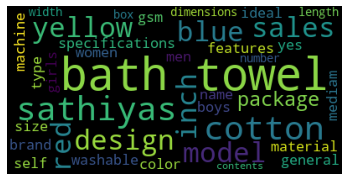

In [85]:
process_step = '2nd stopword'
print(process_step,'  Nombre de stw:',len(data.loc[p_id,'description_stw']))
print(len(process_step)*'-')

content = data['description_stw'].apply(lambda x: ' '.join(x)).iloc[p_id]
print(content)

wordcloud(content)

$\color{orange}{\text{6- POS tagging}}$

is a task of labelling each word in a sentence with its appropriate ***part of speech***. We already know that parts of speech include nouns, verb, adverbs, adjectives, pronouns, conjunction and their sub-categories.

In [97]:
import string
import spacy
sp = spacy.load("en_core_web_sm")

In [99]:
data['description_pos_tags'] = data['description_stw'].apply(lambda x:[t for w, t in nltk.pos_tag(x)])
data['name_pos_tags'] = data['name_stw'].apply(lambda x:[t for w, t in nltk.pos_tag(x)])
data.head(2)

LookupError: ignored

In [ ]:
data['description_pos_tags_sentence'] = data['description_pos_tags'].apply(lambda x: ' '.join(x))
data['name_pos_tags_sentence'] = data['name_pos_tags'].apply(lambda x: ' '.join(x))
data.head(2)

In [88]:
#removes adverbe
adjective_tag_list = ['V','JJ','RB','JJR', 'JJS', 'RBR', 'RBS'] # List of Adjective's,Verbe's tag from nltk package

def remove_adv(text):
  nltk_tokens = nltk.word_tokenize(text)
  corpus  = [word for word, pos in nltk.pos_tag(nltk_tokens) if not  pos in adjective_tag_list] # Select all words that don't have the undesired tags
  return   ' '.join(map(str, corpus))

In [622]:
data['description_adv']=data['description_pos_tags_sentence'].apply(lambda x: remove_adv(x))
data["name_adv"] = data["name_pos_tags_sentence"].apply(lambda x: remove_adv(x))

In [623]:

#test
text=data.pos_tag_sentence[idex]
print('#text originale#:',text)
text_modifier=data['description_adv'][idex]
print('#text modifié#  :',text_modifier)

#text originale#: JJ NNS VBP NN NN JJ NN NN VBP JJ NN NN NN NN JJ NN NN NN VBD JJ NN NN NNS VBP NNS VBP VBN JJ NN NN NN NNS VBP NN NN NN VBG VBZ NN NN JJ NN NN JJ NN JJ NN JJ NN VBP NN NN JJ NN NNS JJ NN JJ JJ NNS JJ NN NN NNS VBP RB JJ RB JJ NN NN JJ NN NN NNS VBP JJ JJ NN JJ NN NN JJ NN NN JJ NNS JJ NN VBN VBG NNS VBP NN NN NN RB NNS VBD NN VB JJ NN VBD NNS NN NN NN JJ NN NN NN VBD RB JJ NN NN VBN NN NN NN NN NN JJ NN NN NN VBN NN NN NN NNS VBP JJ NN NNS NNS VBP JJ NNS NN VBZ JJ JJ NN NN
#text modifié#  : JJ NNS VBP NN NN JJ NN NN VBP JJ NN NN NN NN JJ NN NN NN VBD JJ NN NN NNS VBP NNS VBP VBN JJ NN NN NN NNS VBP NN NN NN VBG VBZ NN NN JJ NN NN JJ NN JJ NN JJ NN VBP NN NN JJ NN NNS JJ NN JJ JJ NNS JJ NN NN NNS VBP RB JJ RB JJ NN NN JJ NN NN NNS VBP JJ JJ NN JJ NN NN JJ NN NN JJ NNS JJ NN VBN VBG NNS VBP NN NN NN RB NNS VBD NN VB JJ NN VBD NNS NN NN NN JJ NN NN NN VBD RB JJ NN NN VBN NN NN NN NN NN JJ NN NN NN VBN NN NN NN NNS VBP JJ NN NNS NNS VBP JJ NNS NN VBZ JJ JJ NN NN


In [624]:
word_size(data,'description_adv')

27

In [ ]:
word_size(data,'description_adv')

In [625]:
data['name_adv'].nunique()

224

### **Reducing the words**
* Stemming
* Lemmatization

$\color{orange}{\text{6- Lemmatization}}$

The real difference between stemming and lemmatization is that Stemming reduces word-forms to (pseudo)stems which might be meaningful or meaningless, whereas lemmatization reduces the word-forms to linguistically valid meaning.

In [89]:
import nltk
nltk.download('wordnet')
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in text]

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [90]:
data['description_lemma']=data['description_stw'].apply(lambda x : lemmatize_text(x))
data['name_lemma']=data['name_stw'].apply(lambda x : lemmatize_text(x))

In [91]:
#test
idex=0
text=data.description[idex]
print('#text originale#:',text)
text_modifier=data['description_lemma'][idex]
print('#text stem#  :',text_modifier)

#text originale#: Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light in your

In [92]:
word_size(data,'description_lemma')

4454

In [93]:
word_size(data,'name_lemma')

1915

$\color{orange}{\text{7- Stemming}}$

In [94]:
data.head(2)

uniq_id                                 image  \
0  55b85ea15a1536d46b7190ad6fff8ce7  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1  7b72c92c2f6c40268628ec5f14c6d590  7b72c92c2f6c40268628ec5f14c6d590.jpg   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   

                                         description category  label_category  \
0  Key Features of Elegance Polyester Multicolor ...     Home               5   
1  Specifications of Sathiyas Cotton Bath Towel (...     Baby               0   

             category_1                                  description_clean  \
0  Curtains&Accessories  Key Features of Elegance Polyester Multicolor ...   
1         BabyBath&Skin  Specifications of Sathiyas Cotton Bath Towel  ...   

                                          name_clean  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   

                               description_tokenized  \
0  [Key, Features, of, Elegance, Polyester, Multi...   
1  [Specifications, of, Sathiyas, Cotton, Bath, T...   

                                      name_tokenized  \
0  [Elegance, Polyester, Multicolor, Abstract, Ey...   
1                    [Sathiyas, Cotton, Bath, Towel]   

                                description_tok_norm  \
0  [Key, Features, of, Elegance, Polyester, Multi...   
1  [Specifications, of, Sathiyas, Cotton, Bath, T...   

                                       name_tok_norm  \
0  [Elegance, Polyester, Multicolor, Abstract, Ey...   
1                    [Sathiyas, Cotton, Bath, Towel]   

                                 description_clean_1  \
0  key features of elegance polyester multicolor ...   
1  specifications of sathiyas cotton bath towel b...   

                             description_clean_tok_2  \
0  [key, features, of, elegance, polyester, multi...   
1  [specifications, of, sathiyas, cotton, bath, t...   

                                description_stopword  \
0  [key, features, elegance, polyester, multicolo...   
1  [specifications, sathiyas, cotton, bath, towel...   

                                       name_stopword  \
0  [Elegance, Polyester, Multicolor, Abstract, Ey...   
1                    [Sathiyas, Cotton, Bath, Towel]   

                                     description_stw  \
0  [key, features, elegance, polyester, multicolo...   
1  [specifications, sathiyas, cotton, bath, towel...   

                                            name_stw  \
0  [Elegance, Polyester, Multicolor, Abstract, Ey...   
1                    [Sathiyas, Cotton, Bath, Towel]   

                                   description_lemma  \
0  [key, feature, elegance, polyester, multicolor...   
1  [specification, sathiyas, cotton, bath, towel,...   

                                          name_lemma  
0  [Elegance, Polyester, Multicolor, Abstract, Ey...  
1                    [Sathiyas, Cotton, Bath, Towel]

In [95]:
stemmer = SnowballStemmer('english')
stemmerport=PorterStemmer()

def stem_text(text):
    words = nltk.word_tokenize(text) # tokenize the text then return a list of tuple (token, nltk_tag)
    
    stem_text = []
    for word in words:
        text=stemmer.stem(word) # Stem each words
        stem_text.append(stemmerport.stem(text)) # Stem each words
    return " ".join(stem_text) # Return the text untokenize

In [96]:
x = data.loc[:, 'description_lemma']
sentence=' '.join(x)
tokens = nltk.word_tokenize(sentence)

TypeError: ignored

In [100]:
data['description_stem'] = data['description_lemma'].apply(lambda x: stem_text(x)) 
data['name_stem'] = data['name_lemma'].apply(lambda x: stem_text(x))

TypeError: ignored

In [ ]:
#test
text=data.description_adv[idex]
print('#text originale#:',text)
text_modifier=data['description_stem'][idex]
print('#text modifié#  :',text_modifier)

supprimer les mots courts

In [639]:
# removes any words composed of less than 2 or more than 21 letters
def short_words(text):
    nltk_tokens = nltk.word_tokenize(text)
    twoLetterWord = []
    for token in nltk_tokens:
        if len(token) <= 2 or len(token) >= 21:
            twoLetterWord.append(token)
    corpus = [word for word in nltk_tokens if word not in twoLetterWord]
    return ' '.join(map(str, corpus)) # Return the text untokenize

In [ ]:
data["description_short"] = data["description_stem"].apply(lambda x: short_words(x))
data["name_short"] = data["name_stem"].apply(lambda x: short_words(x))

### **Frequency calculation**

Term frequency answers the question of, how many times does this word appear in this document, how important is this word to this specific document.

The re. compile() method:

With this method we can combine a regular expression pattern into pattern objects, which can be used for pattern matching. It also helps to search a pattern again without rewriting it

In [346]:
# http://pymotw.com/2/re/

import re
#import the regular expressions

corpus=data['description_stw']
words_dico=dict()

expr =re.compile("\W+",re.U) #  method is used to compile a regular expression pattern provided as a string into a regex pattern object (re.Pattern)
for text in corpus:           # re.U. Interprets letters according to the Unicode character set. This flag affects the behavior of \w, \W, \b, \B. 6.
  text = str(text)
  text = expr.split(text)
  for word in set(text): 
    if word not in words_dico:
      words_dico[word]=1
    else: 
          words_dico[word]=words_dico[word]+1



In [347]:
len(words_dico)

4861

**Frequency exploration**

In [348]:
df_word_freq=pd.DataFrame({'words':words_dico.keys(),'Frequency':words_dico.values()})

In [349]:
df=df_word_freq.sort_values(ascending=False,by='Frequency')
df.head()

words  Frequency
0                   1050
226      free        594
151  products        589
227       buy        576
213  delivery        566

**Droping all the space**

In [350]:
df_word_freq.drop([0],inplace=True, axis=0)

In [351]:
df_word_freq.sort_values(ascending=False,by='Frequency').head()

words  Frequency
226      free        594
151  products        589
227       buy        576
213  delivery        566
231  shipping        564

Text(0.5, 1.0, 'Frequency of words')

<Figure size 1440x720 with 0 Axes>

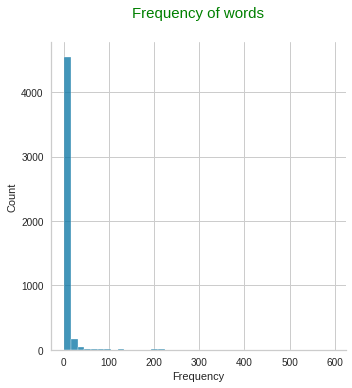

In [352]:
plt.figure(figsize=(20,10))
sns.displot(data=df_word_freq,bins=40, x="Frequency");
plt.title('Frequency of words', fontsize = 15, pad = 25, color='green')

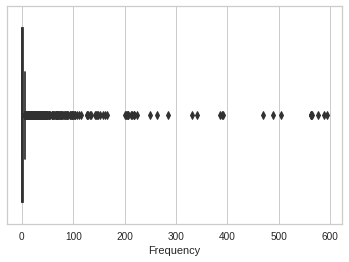

In [353]:
sns.boxplot(data=df_word_freq,x='Frequency');

In [354]:
df_word_freq['Frequency'].describe()

count    4860.000000
mean        6.855967
std        32.102920
min         1.000000
25%         1.000000
50%         1.000000
75%         3.000000
max       594.000000
Name: Frequency, dtype: float64

In [355]:
sorted_freq=df_word_freq.sort_values(by='Frequency',ascending=False)

In [356]:
df1=sorted_freq[0:40]

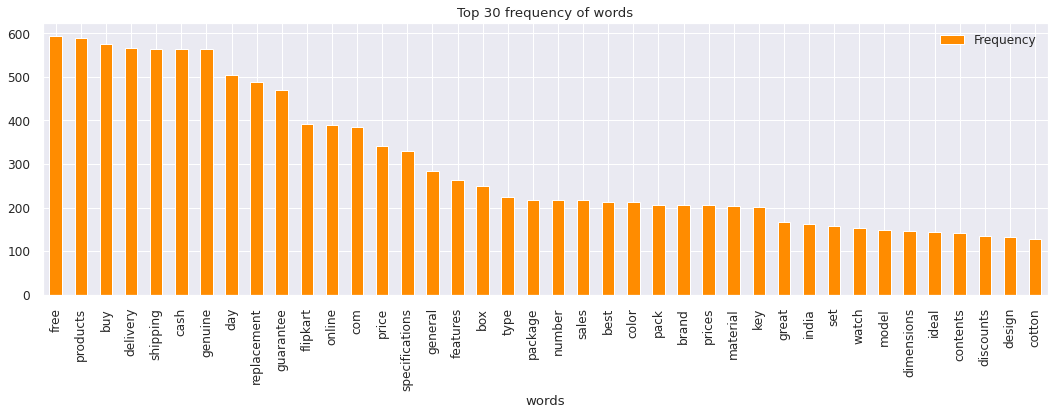

In [357]:

sns.set(font_scale=1.1)
df1.plot(kind='bar',x='words',y='Frequency',title='Top 30 frequency of words',figsize=(18,5) ,color="darkorange")

In [358]:
df2=sorted_freq[-41:-1]

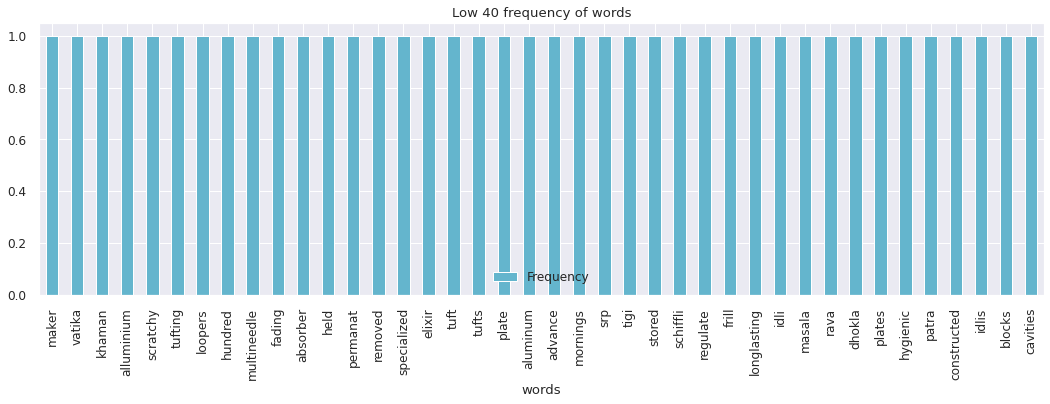

In [359]:
df2.plot(kind='bar',x='words',y='Frequency', color="c",figsize=(18,5),title='Low 40 frequency of words')

In [360]:
len(sorted_freq)

4860


**Removing** all the words which are repeated once! 

**Filtering dataset**

In [361]:
data.head(2)

uniq_id                                 image  \
0  55b85ea15a1536d46b7190ad6fff8ce7  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1  7b72c92c2f6c40268628ec5f14c6d590  7b72c92c2f6c40268628ec5f14c6d590.jpg   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   

                                         description category  label_category  \
0  Key Features of Elegance Polyester Multicolor ...     Home               5   
1  Specifications of Sathiyas Cotton Bath Towel (...     Baby               0   

             category_1                                  description_clean  \
0  Curtains&Accessories  Key Features of Elegance Polyester Multicolor ...   
1         BabyBath&Skin  Specifications of Sathiyas Cotton Bath Towel  ...   

                                          name_clean  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   

                               description_tokenized  \
0  [Key, Features, of, Elegance, Polyester, Multi...   
1  [Specifications, of, Sathiyas, Cotton, Bath, T...   

                                      name_tokenized  \
0  [Elegance, Polyester, Multicolor, Abstract, Ey...   
1                    [Sathiyas, Cotton, Bath, Towel]   

                                description_tok_norm  \
0  [Key, Features, of, Elegance, Polyester, Multi...   
1  [Specifications, of, Sathiyas, Cotton, Bath, T...   

                                       name_tok_norm  \
0  [Elegance, Polyester, Multicolor, Abstract, Ey...   
1                    [Sathiyas, Cotton, Bath, Towel]   

                                 description_clean_1  \
0  key features of elegance polyester multicolor ...   
1  specifications of sathiyas cotton bath towel b...   

                             description_clean_tok_2  \
0  [key, features, of, elegance, polyester, multi...   
1  [specifications, of, sathiyas, cotton, bath, t...   

                                description_stopword  \
0  [key, features, elegance, polyester, multicolo...   
1  [specifications, sathiyas, cotton, bath, towel...   

                                       name_stopword  \
0  [Elegance, Polyester, Multicolor, Abstract, Ey...   
1                    [Sathiyas, Cotton, Bath, Towel]   

                                     description_stw  \
0  [key, features, elegance, polyester, multicolo...   
1  [specifications, sathiyas, cotton, bath, towel...   

                                            name_stw  \
0  [Elegance, Polyester, Multicolor, Abstract, Ey...   
1                    [Sathiyas, Cotton, Bath, Towel]   

                                   description_lemma  
0  [key, feature, elegance, polyester, multicolor...  
1  [specification, sathiyas, cotton, bath, towel,...

In [362]:
text_data= data.filter(items=['image','product_name','category','category_1','label_category','description_lemma'])

In [363]:
print(len(df_word_freq['Frequency'].index[df_word_freq['Frequency']==1]),"words are repeated once")

2662 words are repeated once


In [364]:
rem_list = list(df_word_freq['Frequency'].index[df_word_freq['Frequency']==1])
df_word_freq['words'][rem_list].values

array(['hearts', 'joyous', 'steal', ..., 'receive', 'polyvinyl', 'films'],
      dtype=object)

In [365]:
# remove all the words which are repeated once
#text_data['description_final_1'] = text_data['description_lemma'].apply(lambda x: [i for i in x if i not in df_word_freq['words'][rem_list].values])

In [366]:
#word_size(text_data,'description_final_1')

In [367]:
word_size(text_data,'description_lemma')

4454

## **Bag of words**

The bag-of-words model is a way of representing text data when modeling text with machine learning algorithms.

In [368]:
from sklearn.feature_extraction.text import CountVectorizer

In [369]:
text_data['description_final_1']=text_data['description_lemma']

In [370]:
text_data['description_lemma'][5]

['maserati',
 'time',
 'analog',
 'watch',
 'boy',
 'buy',
 'maserati',
 'time',
 'analog',
 'watch',
 'boy',
 'online',
 'india',
 'flipkart',
 'com',
 'great',
 'discount',
 'genuine',
 'product',
 'day',
 'replacement',
 'guarantee',
 'free',
 'shipping',
 'cash',
 'delivery']

In [371]:
corpus=text_data['description_final_1'].apply(lambda x: ','.join(x))
corpus.head(3)

0    key,feature,elegance,polyester,multicolor,abst...
1    specification,sathiyas,cotton,bath,towel,bath,...
2    key,feature,eurospa,cotton,terry,face,towel,se...
Name: description_final_1, dtype: object

In [372]:
def preprocessor_1(text):
    
    # Initialisation lemmatisation
    lemmatizer = WordNetLemmatizer()
    
    words=re.split("\\s+",text)    
    lemmatized_words=[lemmatizer.lemmatize(word=word,pos='v') for word in words]
    return ' '.join(lemmatized_words)  

In [373]:
#vectorize
tf_vectorizer_1=CountVectorizer( ngram_range=(1,1))
tf_matrix_1 = tf_vectorizer_1.fit_transform(corpus)

In [374]:
features_names=tf_vectorizer_1.get_feature_names()
#dense=X.todense()
#denselist=dense.tolist()
#word_fre_vect=pd.DataFrame(denselist,columns=features_names)
word_fre_vect_uni=pd.DataFrame(tf_matrix_1.toarray(),columns=tf_vectorizer_1.get_feature_names())
word_fre_vect_uni.head(3)

ability  abklgrngrngrn  abklplplpnk  abklplpnkpnk  able  abode  abrasion  \
0        0              0            0             0     0      0         0   
1        0              0            0             0     0      0         0   
2        0              0            0             0     0      0         0   

   abroad  absolute  absorbency  absorbent  absorber  absorbing  absorbs  \
0       0         0           0          0         0          0        0   
1       0         0           0          0         0          0        0   
2       0         0           1          0         0          0        0   

   abstract  accent  access  accessory  accident  accidental  accommodate  \
0         4       0       0          0         0           0            0   
1         0       0       0          0         0           0            0   
2         0       0       0          0         0           0            0   

   accomplishes  according  acer  ache  aching  acid  acne  across  acrylic  \
0             0          0     0     0       0     0     0       0        0   
1             0          0     0     0       0     0     0       0        0   
2             0          0     0     0       0     0     0       0        0   

   act  active  actual  adapter  adaptor  add  added  addiction  adding  \
0    0       0       0        0        0    0      0          0       0   
1    0       0       0        0        0    0      0          0       0   
2    0       0       0        0        0    0      0          0       0   

   addition  additional  additionally  adhesive  adi  adidas  adino  adjust  \
0         0           0             0         0    0       0      0       0   
1         0           0             0         0    0       0      0       0   
2         0           0             0         0    0       0      0       0   

   adjustable  adjusted  adjusts  admiration  admired  adorable  adorn  \
0           0         0        0           0        0         0      0   
1           0         0        0           0        0         0      0   
2           0         0        0           0        0         0      0   

   adorned  adorning  adsl  advance  advice  advisable  aero  affect  \
0        0         0     0        0       0          0     0       0   
1        0         0     0        0       0          0     0       0   
2        0         0     0        0       0          0     0       0   

   affordable  afternoon  agarwood  age  ageless  agrasen  agrees  agromech  \
0           0          0         0    0        0        0       0         0   
1           0          0         0    0        0        0       0         0   
2           0          0         0    0        0        0       0         0   

   aid  aiding  air  airflow  airport  airtel  airtex  airtight  ajmal  \
0    0       0    0        0        0       0       0         0      0   
1    0       0    0        0        0       0       0         0      0   
2    0       0    0        0        0       0       0         0      0   

   akshaj  akup  alarm  alcohol  aleo  alfajr  aline  alive  allin  allover  \
0       0     0      0        0     0       0      0      0      0        0   
1       0     0      0        0     0       0      0      0      0        0   
2       0     0      0        0     0       0      0      0      0        0   

   allow  allowed  allowing  allows  alloy  allpurpose  alluminium  alluring  \
0      0        0         0       0      0           0           0         0   
1      0        0         0       0      0           0           0         0   
2      0        0         0       0      0           0           0         0   

   ally  almond  almost  aloe  aloevera  along  alpha  alphabet  alrams  also  \
0     0       0       0     0         0      0      0         0       0     0   
1     0       0       0     0         0      0      0         0       0     0   
2     0       0       0     0         0      0      0   

In [375]:
word_fre_vect_uni.shape

(1050, 4453)

In [376]:
df=pd.DataFrame({'Word frequancy': word_fre_vect_uni.max().sort_values(ascending=False).index,'Total':word_fre_vect_uni.max().sort_values(ascending=False).values})

In [377]:
df

Word frequancy  Total
0           product     21
1              bowl     21
2            laptop     21
3           blanket     19
4              skin     18
...             ...    ...
4448      financial      1
4449         relief      1
4450     finefinish      1
4451         finger      1
4452          zyxel      1

[4453 rows x 2 columns]

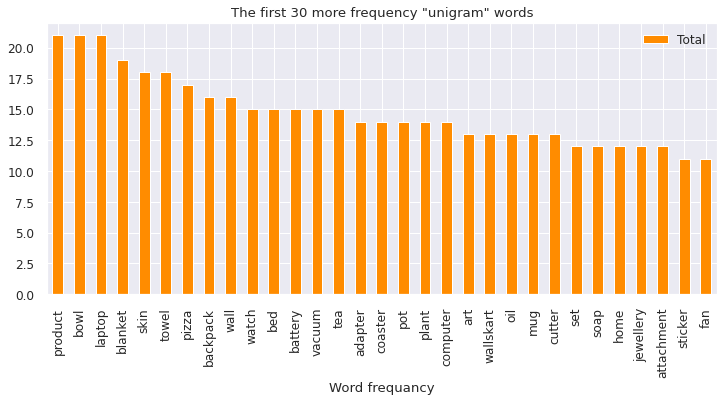

In [378]:

df1=df.loc[0:30,['Word frequancy','Total']]

df1.plot(kind='bar',x='Word frequancy',y='Total', color="darkorange",title='The first 30 more frequency "unigram" words',figsize=(12,5))


In [379]:
tf_vectorizer_2=CountVectorizer(min_df=2,max_df=0.75, ngram_range=(1,2))
tf_matrix_2 = tf_vectorizer_2.fit_transform(corpus)

In [380]:
features_names=tf_vectorizer_2.get_feature_names()
word_fre_vect_bi=pd.DataFrame(tf_matrix_2.toarray(),columns=tf_vectorizer_2.get_feature_names())

In [381]:
df_v2=pd.DataFrame({'Word frequancy': word_fre_vect_bi.max().sort_values(ascending=False).index,'Total':word_fre_vect_bi.max().sort_values(ascending=False).values})

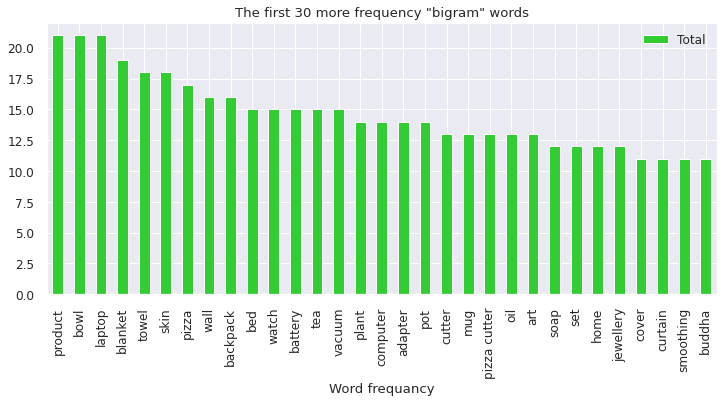

In [382]:
df2=df_v2.loc[0:30,['Word frequancy','Total']]

df2.plot(kind='bar',x='Word frequancy',y='Total', color="limegreen",title='The first 30 more frequency "bigram" words',figsize=(12,5))

### **TF IDF**
Term frequency-inverse document frequency

Text vectorization algorithm namely TF-IDF vectorizer, which is a very popular approach for traditional machine learning algorithms can help in transforming text into vectors.
tf–idf can be successfully used for stop-words filtering in various subject fields, including text summarization and classification. One of the simplest ranking functions is computed by summing the tf–idf for each query term; many more sophisticated ranking functions are variants of this simple model.

TF-IDF is better than Count Vectorizers because it not only focuses on the frequency of words present in the corpus but also provides the importance of the words. We can then remove the words that are less important for analysis, hence making the model building less complex by reducing the input dimensions

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

In [383]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [384]:
# unigrams
tfidf_vectorizer_1 = TfidfVectorizer(max_df=0.5,
        max_features=opts.n_features,
        min_df=2,
        stop_words="english",
        use_idf=opts.use_idf,)
tfidf_matrix_1 = tfidf_vectorizer_1.fit_transform(corpus)


In [385]:
features_names=tfidf_vectorizer_1.get_feature_names()
dense=tfidf_matrix_1.todense()
denselist=dense.tolist()
words_freq_1=pd.DataFrame(denselist,columns=features_names)
words_freq_1.head(3)

ability  able  abode  absorbency  absorbent  abstract  accent  access  \
0      0.0   0.0    0.0    0.000000        0.0   0.17734     0.0     0.0   
1      0.0   0.0    0.0    0.000000        0.0   0.00000     0.0     0.0   
2      0.0   0.0    0.0    0.075168        0.0   0.00000     0.0     0.0   

   accessory  accident  accidental  according  act  actual  adapter  adaptor  \
0        0.0       0.0         0.0        0.0  0.0     0.0      0.0      0.0   
1        0.0       0.0         0.0        0.0  0.0     0.0      0.0      0.0   
2        0.0       0.0         0.0        0.0  0.0     0.0      0.0      0.0   

   add  addition  additional  adhesive  adidas  adjustable  admired  adorable  \
0  0.0       0.0         0.0       0.0     0.0         0.0      0.0       0.0   
1  0.0       0.0         0.0       0.0     0.0         0.0      0.0       0.0   
2  0.0       0.0         0.0       0.0     0.0         0.0      0.0       0.0   

   adorn  adsl  advice  aero  affect  affordable  age  aid  air  akup  alarm  \
0    0.0   0.0     0.0   0.0     0.0         0.0  0.0  0.0  0.0   0.0    0.0   
1    0.0   0.0     0.0   0.0     0.0         0.0  0.0  0.0  0.0   0.0    0.0   
2    0.0   0.0     0.0   0.0     0.0         0.0  0.0  0.0  0.0   0.0    0.0   

   alfajr  aline  allin  allow  allowed  allowing  allows  alloy  alluring  \
0     0.0    0.0    0.0    0.0      0.0       0.0     0.0    0.0       0.0   
1     0.0    0.0    0.0    0.0      0.0       0.0     0.0    0.0       0.0   
2     0.0    0.0    0.0    0.0      0.0       0.0     0.0    0.0       0.0   

   almond  aloevera  alternative  aluminium  amazed  amazing  ambience  \
0     0.0       0.0          0.0        0.0     0.0      0.0       0.0   
1     0.0       0.0          0.0        0.0     0.0      0.0       0.0   
2     0.0       0.0          0.0        0.0     0.0      0.0       0.0   

   analog  analogdigital  andre  android  angel  animal  anna  anodised  \
0     0.0            0.0    0.0      0.0    0.0     0.0   0.0       0.0   
1     0.0            0.0    0.0      0.0    0.0     0.0   0.0       0.0   
2     0.0            0.0    0.0      0.0    0.0     0.0   0.0       0.0   

        ant      anti  antiaging  antibacterial  antidepressant  antique  \
0  0.070561  0.068164        0.0            0.0             0.0      0.0   
1  0.000000  0.000000        0.0            0.0             0.0      0.0   
2  0.000000  0.000000        0.0            0.0             0.0      0.0   

   antiqueshop  antiseptic  anymore    apart  app  apparel    appeal  \
0          0.0         0.0      0.0  0.07365  0.0      0.0  0.063118   
1          0.0         0.0      0.0  0.00000  0.0      0.0  0.000000   
2          0.0         0.0      0.0  0.00000  0.0      0.0  0.000000   

   appealing  appearance  appears  apple  application  applied  apply  \
0        0.0         0.0      0.0    0.0          0.0      0.0    0.0   
1        0.0         0.0      0.0    0.0          0.0      0.0    0.0   
2        0.0         0.0      0.0    0.0          0.0      0.0    0.0   

   approach  approx  arabian  arb  archies  area  aroma  art  artifact  \
0       0.0     0.0      0.0  0.0      0.0   0.0    0.0  0.0       0.0   
1       0.0     0.0      0.0  0.0      0.0   0.0    0.0  0.0       0.0   
2       0.0     0.0      0.0  0.0      0.0   0.0    0.0  0.0       0.0   

   artificial  artisan  artist  artistic  artpiece  artwork  asia  aspect  \
0         0.0      0.0     0.0       0.0       0.0      0.0   0.0     0.0   
1         0.0      0.0     0.0       0.0       0.0      0.0   0.0     0.0   
2         0.0      0.0     0.0       0.0       0.0      0.0   0.0     0.0   

   assembled  assembly  assorted  assure  assured  astringent  asus  \
0        0.0       0.0  0.000000     0.0      0.0         0.0   0.0   
1        0.0       0.0  0.000000     0.0      0.0         0.0   0.0   
2        0.0       0.0  0.202716     0.0      0.0         0.0   0.0   

   attention  attitude  attivo  attractive

In [386]:
words_freq_1.shape 

(1050, 1942)

In [387]:
df=pd.DataFrame({'word_freq': words_freq_1.max().sort_values(ascending=False).index,'Total':words_freq_1.max().sort_values(ascending=False).values})

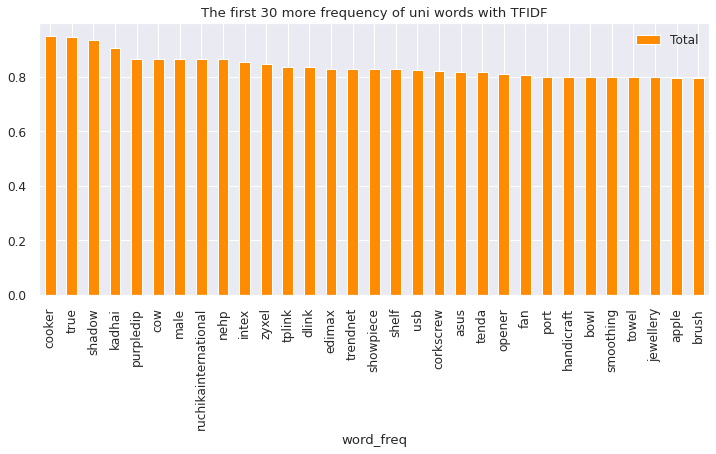

In [388]:
df1=df.loc[0:30,['word_freq','Total']]#les 20mots les plus frequents 
df1.plot(kind='bar',x='word_freq',y='Total', color="darkorange",title='The first 30 more frequency of uni words with TFIDF',figsize=(12,5))

In [389]:
# unigram & bigrams
tfidf_vectorizer_2=CountVectorizer(min_df=2,max_df=0.75, ngram_range=(1,2))
tfidf_matrix_2 = tfidf_vectorizer_2.fit_transform(corpus)

In [390]:
features_names=tf_vectorizer_2.get_feature_names()
dense=tf_matrix_2.todense()
denselist=dense.tolist()
words_freq_2=pd.DataFrame(denselist,columns=features_names)
words_freq_2.head(3)

ability  able  able light  abode  absorbency  absorbent  abstract  \
0        0     0           0      0           0          0         4   
1        0     0           0      0           0          0         0   
2        0     0           0      0           1          0         0   

   abstract art  abstract ceramic  abstract cushion  abstract design  \
0             0                 0                 0                0   
1             0                 0                 0                0   
2             0                 0                 0                0   

   abstract double  abstract eyelet  abstract floral  abstract single  accent  \
0                0                3                0                0       0   
1                0                0                0                0       0   
2                0                0                0                0       0   

   access  accessory  accessory battery  accident  accidental  \
0       0          0                  0         0           0   
1       0          0                  0         0           0   
2       0          0                  0         0           0   

   accidental damage  according  across  across world  act  actual  \
0                  0          0       0             0    0       0   
1                  0          0       0             0    0       0   
2                  0          0       0             0    0       0   

   actual product  adapter  adapter also  adapter charger  adapter come  \
0               0        0             0                0             0   
1               0        0             0                0             0   
2               0        0             0                0             0   

   adapter conforms  adapter designed  adapter equipped  adapter general  \
0                 0                 0                 0                0   
1                 0                 0                 0                0   
2                 0                 0                 0                0   

   adapter key  adapter laptop  adapter model  adapter output  adapter pin  \
0            0               0              0               0            0   
1            0               0              0               0            0   
2            0               0              0               0            0   

   adapter please  adapter power  adapter price  adapter voltage  adaptor  \
0               0              0              0                0        0   
1               0              0              0                0        0   
2               0              0              0                0        0   

   adaptor usb  add  add elegance  add kitchen  add spunk  add touch  \
0            0    0             0            0          0          0   
1            0    0             0            0          0          0   
2            0    0             0            0          0          0   

   addition  addition kitchen  additional  additional detail  \
0         0                 0           0                  0   
1         0                 0           0                  0   
2         0                 0           0                  0   

   additional feature  additional trait  adhesive  adhesive pvc  \
0                   0                 0         0             0   
1                   0                 0         0             0   
2                   0                 0         0             0   

   adhesive sticker  adidas  adidas ice  adjustable  adjustable shoulder  \
0                 0       0           0           0                    0   
1                 0       0           0           0                    0   
2                 0       0           0           0                    0   

   admired  admired guest  adorable  adorable fantastic  adorn  adsl  \
0        0              0         0                   0      0     0   
1        0              0         0                   0      0    

In [391]:
words_freq_2.shape

(1050, 5771)

In [392]:
df_2=pd.DataFrame({'word_freq': words_freq_2.max().sort_values(ascending=False).index,'Total':words_freq_2.max().sort_values(ascending=False).values})


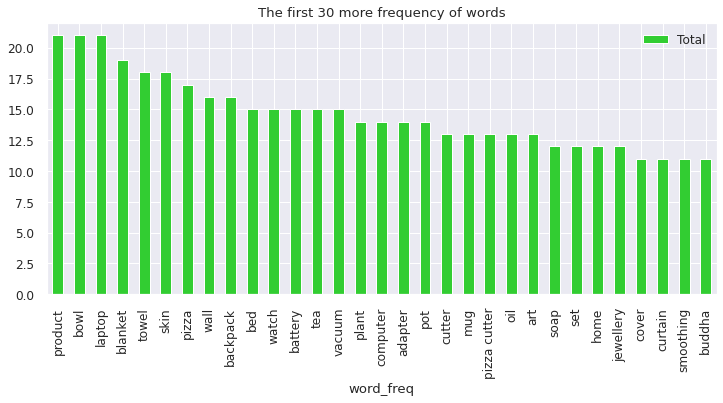

In [393]:
df1=df_2.loc[0:30,['word_freq','Total']]#les 20mots les plus frequents 
df1.plot(kind='bar',x='word_freq',y='Total', color="limegreen",title='The first 30 more frequency of words',figsize=(12,5))

Making a **new file**

In [141]:
# All the data in TFIDF with image & product_category 'df_tfidfvect_total'
"""
from google.colab import drive
drive.mount('/content/drive')
df_total_1.to_csv('df_total_1.csv', index=False)
!cp new_df.csv /content/drive/My\ Drive/"""

"\nfrom google.colab import drive\ndrive.mount('/content/drive')\ndf_total_1.to_csv('df_total_1.csv', index=False)\n!cp new_df.csv /content/drive/My\\ Drive/"

In [ ]:
# all words after TFIDF 'words_freq' unigram
"""from google.colab import drive
drive.mount('/content/drive')
words_freq_1.to_csv('words_freq_1.csv', index=False)
!cp new_df.csv /content/drive/My\ Drive/"""

In [ ]:
# all words after TFIDF 'words_freq' bigram et unigram
from google.colab import drive
drive.mount('/content/drive')
words_freq_3.to_csv('words_freq_3.csv', index=False)
!cp new_df.csv /content/drive/My\ Drive/

In [ ]:
# our first dataset after cleaning 'text_data'
"""text_data= data.filter(items=['image','product_name','category','category_1','description_lemma_short','name_lemma_short'])"""

from google.colab import drive
drive.mount('/content/drive')
text_data.to_csv('text_data.csv', index=False)
!cp new_df.csv /content/drive/My\ Drive/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/My\Drive/p6
!ls

text_data = pd.read_csv('/content/drive/MyDrive/p6/text_data.csv')

/content/drive/MyDrive/p6
'Classifier automatiquement des biens de consommation.ipynb'   image
 clustering_model_kmeans_description.sav		       new_df.csv
 df_tfidfvect.csv					       results.txt
 df_tfidfvect_total.csv					       text_data.csv
 df_total_1.csv						       words_freq_1.csv
 df_untokenize_description.csv				       words_freq_3.csv
 flipkart_com-ecommerce_sample_1050.csv			       words_freq.csv


In [142]:
text_data.head(2)

image  \
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1  7b72c92c2f6c40268628ec5f14c6d590.jpg   

                                        product_name category  \
0  Elegance Polyester Multicolor Abstract Eyelet ...     Home   
1                         Sathiyas Cotton Bath Towel     Baby   

             category_1  label_category  \
0  Curtains&Accessories               5   
1         BabyBath&Skin               0   

                                   description_lemma  \
0  [key, feature, elegance, polyester, multicolor...   
1  [specification, sathiyas, cotton, bath, towel,...   

                                 description_final_1  
0  [key, feature, elegance, polyester, multicolor...  
1  [specification, sathiyas, cotton, bath, towel,...

In [143]:
text_data.describe()

label_category
count     1050.000000
mean         3.000000
std          2.000953
min          0.000000
25%          1.000000
50%          3.000000
75%          5.000000
max          6.000000

### **Dimentional reduction**

In [394]:
tfidf_matrix_1.shape

(1050, 1942)

In [395]:
tfidf_matrix_2.shape

(1050, 5771)

In [396]:
tf_matrix_1.shape

(1050, 4453)

In [397]:
tf_matrix_2.shape

(1050, 5771)

In [398]:
from sklearn.decomposition import SparsePCA
from sklearn.manifold import TSNE

def plot_tsne_pca(matrix,title,labels):

# Dimensionality reduction using PCA,
     # reduce the tfidf matrix to just 2 features

    pca = PCA(n_components=2, random_state=5).fit_transform(matrix)
    tsne_pca = TSNE().fit_transform(PCA(n_components=3).fit_transform(matrix))
    tsne = TSNE(n_components=2, random_state=5).fit_transform(matrix)   

    #attaching the label to each 2D projection
    pca_data=np.vstack((pca.T,labels)).T
    pca_df=pd.DataFrame(pca_data, columns=['pca-one','pca-two','category'])

    tsne_data=np.vstack((tsne.T,labels)).T
    tsne_df=pd.DataFrame(tsne_data, columns=['tsne-one','tsne-two','category'])
    
    
    idx = np.random.choice(range(pca.shape[0]), size=500, replace=False)
    
    f, ax = plt.subplots(1, 2, figsize=(14, 6))

    sns.scatterplot(data=pca_df, x="pca-one", y="pca-two",
                    hue='category', ax=ax[0])
    
    ax[0].set_title('PCA Cluster Plot'+' '+title)

    sns.scatterplot(data=tsne_df, x="tsne-one", y="tsne-two",
                    hue='category', ax=ax[1])
    
    ax[1].set_title('TSNE Cluster Plot'+' '+title)

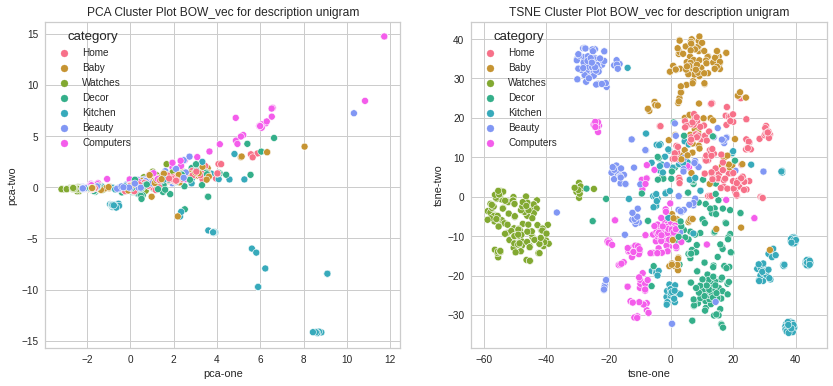

In [168]:
plot_tsne_pca(tf_matrix_1.todense(),'BOW_vec for description unigram',text_data['category'])

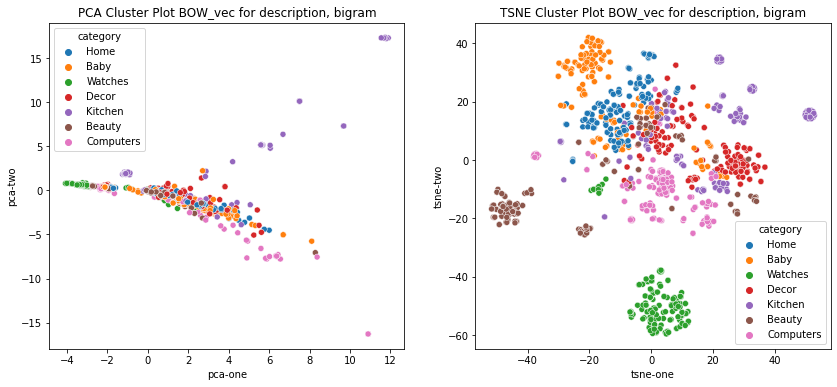

In [ ]:
plot_tsne_pca(tf_matrix_2.todense(),'BOW_vec for description, bigram',text_data['category'])

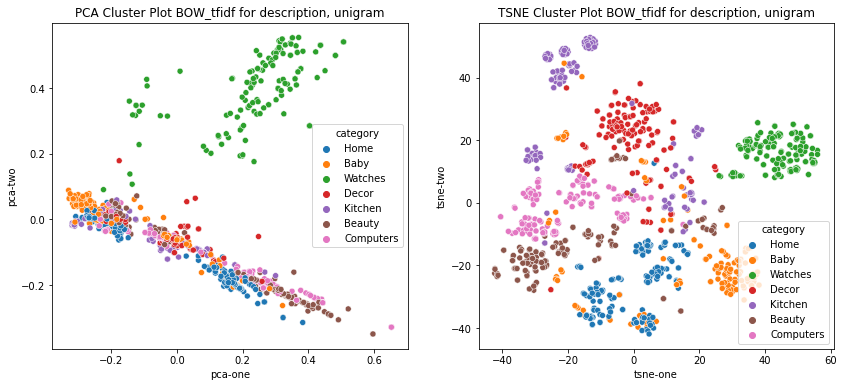

In [ ]:
plot_tsne_pca(tfidf_matrix_1.todense(),'BOW_tfidf for description, unigram',text_data['category'])

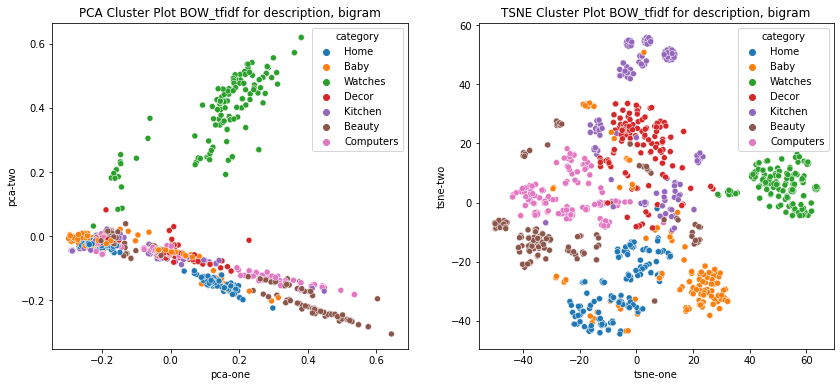

In [ ]:
plot_tsne_pca(tfidf_matrix_2.todense(),'BOW_tfidf for description, bigram',text_data['category'])

Bag of Words (CountVectorizer) / TruncatedSVD

In [399]:
X = tf_matrix_1

# Transformation TruncatedSVD
svd = TruncatedSVD(n_components=600, n_iter=7, random_state=24)
X_cv_trSVD = svd.fit_transform(X)
print('Dimensions X_cv_trSVD:',X_cv_trSVD.shape)

# Variances explicatives cumulées
var_cum = svd.explained_variance_ratio_.cumsum().max()
print('Variances explicatives cumulées:',round(var_cum,2))


Dimensions X_cv_trSVD: (1050, 600)
Variances explicatives cumulées: 0.99


Bag of Words (TfidfVectorizer) / TruncatedSVD

In [400]:
X = tfidf_matrix_1

# Transformation TruncatedSVD
svd = TruncatedSVD(n_components=600, n_iter=7, random_state=24)
X_tv_trSVD = svd.fit_transform(X)
print('Dimensions X_tv_trSVD:',X_tv_trSVD.shape)

# Variances explicatives cumulées
var_cum = svd.explained_variance_ratio_.cumsum().max()
print('Variances explicatives cumulées:',round(var_cum,2))

Dimensions X_tv_trSVD: (1050, 600)
Variances explicatives cumulées: 0.98


Doc2Vec / TruncatedSVD

In [401]:
X = X_d2v

# Transformation TruncatedSVD
svd = TruncatedSVD(n_components=60, n_iter=7, random_state=rs_)
X_d2v_trSVD = svd.fit_transform(X)
print('Dimensions X_d2v_trSVD:',X_d2v_trSVD.shape)

# Variances explicatives cumulées
var_cum = svd.explained_variance_ratio_.cumsum().max()
print('Variances explicatives cumulées:',round(var_cum,2))

NameError: ignored

Bag of Words (CountVectorizer) / t-SNE

In [402]:
reduc_dim_ = 0 ###param
print('Paramètre reduc_dim_ = ',reduc_dim_)

Paramètre reduc_dim_ =  0


In [403]:
if reduc_dim_ == 1:

    X = tf_matrix_1.toarray()

    # Transformation t_SNE
    tsne = TSNE(n_components=2, random_state=rs_, init='pca', method='exact')
    X_emb_1 = tsne.fit_transform(X)
    joblib.dump(X_emb_1, 'X_emb_1.joblib')
    print('Dimensions X_emb_1:',X_emb_1.shape)

In [180]:
X = tf_matrix_1.toarray()

# Transformation t_SNE
tsne = TSNE(n_components=5, random_state=24, init='pca', method='exact')
X_emb_1 = tsne.fit_transform(X)
print('Dimensions X_emb_1:',X_emb_1.shape)

Dimensions X_emb_1: (1050, 5)
KL divergence: 2.55


Bag of Words (TfidfVectorizer) / t-SNE

In [181]:
print('Paramètre reduc_dim_ = ',reduc_dim_)

Paramètre reduc_dim_ =  0


In [182]:
if reduc_dim_ == 1:
    
    X = tfidf_matrix_1.toarray()

    # Transformation t_SNE
    tsne = TSNE(n_components=2, random_state=rs_, init='pca', method='exact')
    X_emb_1 = tsne.fit_transform(X)
    print('Dimensions X_emb_1:',X_emb_1.shape)

In [184]:
X = tfidf_matrix_1.toarray()

# Transformation t_SNE
tsne = TSNE(n_components=5, random_state=24, init='pca', method='exact')
X_emb_1 = tsne.fit_transform(X)
print('Dimensions X_emb_1:',X_emb_1.shape)


Dimensions X_emb_1: (1050, 5)


In [191]:
X_emb_1

array([[ 9.955173  ,  5.810821  , -0.95261157,  4.2706714 , -1.9531366 ],
       [-3.3401017 ,  2.5998945 , -3.2321544 ,  7.188706  , -2.3235722 ],
       [-5.0836673 ,  1.4740653 , -3.296171  ,  7.547183  , -3.999067  ],
       ...,
       [-4.9188204 ,  7.18248   , -0.5079959 , -4.4834557 ,  3.0547972 ],
       [-5.6834526 ,  8.128074  , -1.4439286 , -2.878508  ,  0.6778281 ],
       [-4.995542  ,  7.397364  , -0.86465687, -4.2702975 ,  2.581415  ]],
      dtype=float32)

## **Classification**

### **KMean**

https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html

In [404]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn import metrics, cluster

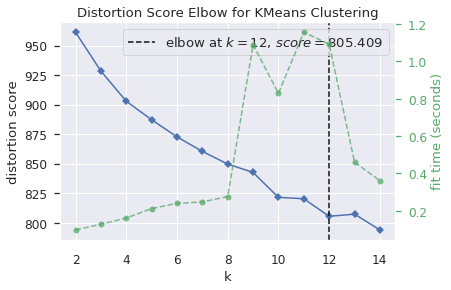

In [421]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,15))

visualizer.fit(tfidf_matrix_1)   #unigram
visualizer.poof()

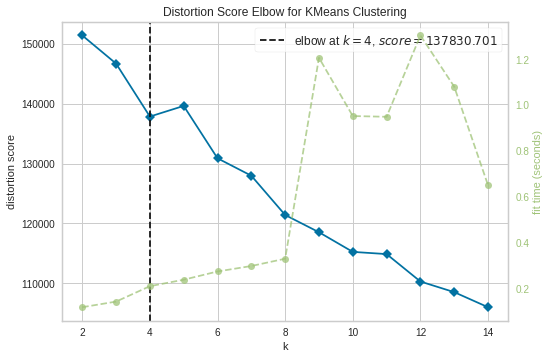

In [150]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,15))

visualizer.fit(tfidf_matrix_2)   #unigram & bigram
visualizer.poof()

In [466]:
pip install -U gensim

     |████████████████████████████████| 24.1 MB 1.7 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [467]:
from sklearn.decomposition import NMF
from gensim.models.nmf import Nmf 

In [474]:
#define vectorizer parameters
from sklearn.feature_extraction.text import CountVectorizer

def BOVW_TF(X,n_gram):
    tfidf_vectorizer = TfidfVectorizer(
        min_df=2,
        max_df=0.9,
        max_features=5000,
        ngram_range=n_gram)
    tf_vectorizer=CountVectorizer(
        min_df=2,
        max_df=0.9,
        max_features=5000,
        ngram_range=n_gram)
    # Generate matrix of word vectors
    # tf-idf (term frequency-inverse document frequency)
    tfidf_matrix = tfidf_vectorizer.fit_transform(X)
    tfidf_words = tfidf_vectorizer.get_feature_names()

    # bag of words (term frequency)
    tf_matrix=tf_vectorizer.fit_transform(X)
    tf_words = tf_vectorizer.get_feature_names()

    return tfidf_matrix,tf_matrix

In [476]:
tfidf_matrix_N,tf_matrix_N=BOVW_TF(corpus.copy(),n_gram=(1,2))


In [493]:
k=7#nbr of cluster
def kmeans_clustering(tfidf_matrix,tf_matrix,k):

    nmf = NMF(n_components=k)
    nmf_matrix = nmf.fit_transform(tfidf_matrix_1)


    lda = LatentDirichletAllocation(k, learning_method='batch')
    lda_tf = lda.fit_transform(tf_matrix_1)

    # Singular Value Decomposition
    lsa = TruncatedSVD(n_components=100)

    matrix1=tfidf_matrix.copy()
    matrix2=tf_matrix.copy()

    lsa_tfidf = lsa.fit_transform(matrix1)
    lsa_tf = lsa.fit_transform(matrix2)
    # initialize standardscaler
    from sklearn.preprocessing import StandardScaler
    from sklearn.preprocessing import Normalizer,MinMaxScaler

    SS = Normalizer()
 # transform my reducer data using standardscaler

    #tfidf=SS.fit_transform(X)
    #tf=SS.fit_transform(Y)
    #lsa_tfidf_std = SS.fit_transform(lsa_matrix_tfidf)
    #lsa_tf_std = SS.fit_transform(lsa_matrix_tf)
    #nmf_tfidf_std = SS.fit_transform(nmf_matrix)
    #lda_tf_std = SS.fit_transform(lda_matrix)
    #X_emb_std=SS.fit_transform(X_emb)
    km_tfidf = KMeans(n_clusters = k,init = 'random'
                          , n_init = 50, random_state = 20
                          , algorithm = 'full').fit(tfidf_matrix_1) 
    km_tf = KMeans(n_clusters = k,init = 'random'
                          , n_init = 50, random_state = 20
                          , algorithm = 'full').fit(tf_matrix_1)
      
 

    return km_tfidf, km_tf

In [494]:
km_tfidf_N,km_tf_N  =  kmeans_clustering(tfidf_matrix_N,tf_matrix_N,k=7)
#nmf_matrix_NF,lda_tf_NF,km_tfidf_NF,km_tf_NF,km_nmf_NF,km_lsa_tf_NF,km_lsa_tfidf_NF,km_lda_NF,km_emb_NF=kmeans_clustering(tfidf_matrix_NF,tf_matrix_NF,X_emb_NF,k=7)

In [495]:
from sklearn.metrics import make_scorer,adjusted_rand_score
from sklearn.model_selection import GridSearchCV

#nombre de cluster
n_clusters=7

#initier le modèle kmeans avec les parametres defaut
km=KMeans(n_clusters=n_clusters)
#le score à optimiser
score=make_scorer(adjusted_rand_score)
#les hyperparametres à optimiser
parameters = {'init':('k-means++', 'random'),
              'max_iter':[50,100,120],#Nombre de fois où l'algorithme k-means sera exécuté avec différentes valeurs de centroïde. Les résultats finaux seront la meilleure sortie de n_init exécutions consécutives en termes d'inertie.
              'n_init':[5,10,15],#Nombre maximum d'itérations de l'algorithme k-means pour une seule exécution.
              'algorithm':['auto', 'full', 'elkan'],#Algorithme K-means à utiliser
              'random_state': [20,25,30,40,60,]}#Détermine la génération de nombres aléatoires pour l'initialisation du centre de gravité. Utilisez un int pour rendre le caractère aléatoire déterministe

#recherche sur gride

grid = GridSearchCV(km, parameters,scoring=score)
grid.fit(lda_tf,data.category_mo)
index_grid=grid.cv_results_['rank_test_score'].tolist().index(1)
print("ARI score mean :"+str(grid.cv_results_['mean_test_score'][index_grid]))
print("Best parameters: "+str(grid.best_params_))

NameError: ignored

In [496]:
def Ari_score (df,label,label_tru):
  cluster  = {0:'Baby',
            1:'Decor',
            2:'Computers',
            3:'Watches',
            4:'Kitchen',
            5:'Home',
            6:'Beauty'}

  # Prep
  k_labels = df[label].map(cluster)  # Get cluster labels
  k_labels_matched = np.empty_like(k_labels)

  # For each cluster label...
  for k in np.unique(k_labels):

    # ...find and assign the best-matching truth label
    match_nums = [np.sum((k_labels==k)*(label_tru==t)) for t in np.unique(label_tru)]
    k_labels_matched[k_labels==k] = np.unique(label_tru)[np.argmax(match_nums)]
  #confusion_matrix
  conf_mat = confusion_matrix(label_tru, k_labels_matched)

  #compute ARI SCORE
  ari_score=adjusted_rand_score(label_tru, k_labels_matched)
  homogeneity=homogeneity_score(label_tru, k_labels_matched)

  return ari_score,homogeneity

In [497]:
def data_ari(df,Title):
    liste=['cluster_nmf','cluster_lda','cluster_nmf_km','cluster_lda_km',
          'cluster_lsa_tfidf','cluster_lsa_tf','cluster_emb','cluster_tfidf',
          'cluster_tf']

    ARI=[]
    for cluster in liste:
      ari,homg=Ari_score (df,cluster,
                            data['category'])
      ARI.append([ari,homg])


    df_ari=pd.DataFrame(ARI
                        ,index=['cluster_nmf','cluster_lda',
                        'nmf_km','lda_km',
                        'lsa_tfidf_km','lsa_tf_km',
                        'emb_km',
                        'tfidf_km',
                        'tf_km'],
                        columns=['ARI_SCORE','Homogeneity_score'])
    
  
    #display scores of  each Scaler

    tab_score=df_ari.round(3)

    #plot bar each Scaler 
    barWidth = 0.25# the width of the bars

    r1 = np.arange(len(tab_score))
    r2 = [x + barWidth for x in r1]
    fig, ax = plt.subplots(figsize=(12,7))

    rec1=ax.bar(r1,
                tab_score['ARI_SCORE'],
                color='darkorange',
                width=barWidth,
                label='ARI_SCORE')
    rec2=ax.bar(r2,
                tab_score['Homogeneity_score'],
                color='teal',
                width=barWidth,
                label='Homogeneity_score')

    for rect in rec1 :
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1*height,
                '{:1.2f}'.format(height),
                ha='center', va='bottom')
    for rect in rec2 :
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1*height,
                '{:1.2f}'.format(height),
                ha='center', va='bottom')
    # add some text for labels, title and axes ticks
    ax.set_title('Comparaison des performances Kmeans'+' '+Title, fontsize = 20)
    ax.set_xlabel('Models', fontsize = 15)
    ax.set_ylabel('Scores', fontsize = 15)
    ax.set_ylim(top=1)
    plt.xticks(r1, tab_score.index)
    ax.legend()
    plt.show()

In [498]:
data_ari(df_name_final,'for:Name_Final')

NameError: ignored

In [439]:
km_model =cluster.KMeans(n_clusters=7,
        init="k-means++",
        algorithm = 'auto',
        random_state = 42,
        n_init=1)

# tfidf_matrix_1 : tfidf_unigram
model_1 = km_model.fit(tfidf_matrix_1)

# tfidf_matrix_2 : tfidf_unigram & bigram
model_2 = km_model.fit(X_emb_1)

# tf_matrix_1   :  tf_vectorize_unigram
model_3 = km_model.fit(tf_matrix_1)

# tf_matrix_2   :  tf_vectorize_unigram & bigram
model_4 = km_model.fit(X_cv_trSVD)

In [440]:
labels_kmeans_1 = pd.DataFrame(model_1.labels_, columns=['KMC_tfidf_unigram'])
labels_kmeans_2 = pd.DataFrame(model_2.labels_, columns=['KMC_tfidf_bigram'])
labels_kmeans_3 = pd.DataFrame(model_3.labels_, columns=['KMC_tf_vectorize_unigram'])
labels_kmeans_4 = pd.DataFrame(model_4.labels_, columns=['KMC_tf_vectorize_bigram'])

In [441]:
tot_data_label = pd.concat([text_data['category'], text_data['label_category'], labels_kmeans_1,labels_kmeans_2,labels_kmeans_3,labels_kmeans_4], axis=1)
tot_data_label.tail()

category  label_category  KMC_tfidf_unigram  KMC_tfidf_bigram  \
1045     Baby               0                  3                 3   
1046     Baby               0                  3                 3   
1047     Baby               0                  3                 3   
1048     Baby               0                  3                 3   
1049     Baby               0                  3                 3   

      KMC_tf_vectorize_unigram  KMC_tf_vectorize_bigram  
1045                         3                        3  
1046                         3                        3  
1047                         3                        3  
1048                         3                        3  
1049                         3                        3

In [429]:
ARI_kmeans_1 = adjusted_rand_score( tot_data_label['label_category'], tot_data_label['KMC_tfidf_unigram'])
ARI_kmeans_2 = adjusted_rand_score( tot_data_label['label_category'], tot_data_label['KMC_tfidf_bigram'])
ARI_kmeans_3 = adjusted_rand_score( tot_data_label['label_category'], tot_data_label['KMC_tf_vectorize_unigram'])
ARI_kmeans_4 = adjusted_rand_score( tot_data_label['label_category'], tot_data_label['KMC_tf_vectorize_bigram'])


In [430]:
ARI= pd.DataFrame({'columns':['KM_tfidf_unigram','KM_tfidf_bigram','KMC_tf_vectorize_unigram','KMC_tf_vectorize_bigram'],
                   'ARI':[ARI_kmeans_1,ARI_kmeans_2, ARI_kmeans_3, ARI_kmeans_4]})

In [431]:
ARI

columns       ARI
0          KM_tfidf_unigram  0.009767
1           KM_tfidf_bigram  0.009767
2  KMC_tf_vectorize_unigram  0.009767
3   KMC_tf_vectorize_bigram  0.009767

In [ ]:
ARI

columns       ARI
0          KM_tfidf_unigram  0.166664
1           KM_tfidf_bigram  0.166664
2  KMC_tf_vectorize_unigram  0.166664
3   KMC_tf_vectorize_bigram  0.166664

In [ ]:
ARI= pd.DataFrame({'columns':['KM_tfidf_unigram','KM_tfidf_bigram'],
                   'ARI':[ARI_kmeans_1,ARI_kmeans_2]})

In [ ]:
ARI

columns       ARI
0  KM_tfidf_unigram  0.234981
1   KM_tfidf_bigram  0.234981

In [166]:
df_X_kmeans = df_X1ts.merge(df_X3ts, left_index=True, right_index=True)
#df_X_kmeans = df_X_kmeans.merge(df_X2ts, left_index=True, right_index=True)

NameError: ignored

In [158]:
! pip install KPrototypes

In [161]:
! pip install kmodes

In [162]:
from kmodes.kprototypes import KPrototypes

In [165]:
df_X_kpro = df_X_kmeans
df_X_kpro = df_X_kpro.merge(df_X4, left_index=True, right_index=True)
df_X_kpro.head(3)

NameError: ignored

In [164]:
kpro_cost_ = 1 ###param

if kpro_cost_ == 1:    
    cost = []    
    for num_clusters in list(range(1,12)):        
        kpro = KPrototypes(n_clusters = num_clusters,
                           init = 'Cao',                           
                           n_init = 1,
                           verbose = 0,
                           random_state = 24)        
        kpro.fit_predict(df_X_kpro, categorical=[len(df_X_kpro.columns.tolist())-1])        
        cost.append(kpro.cost_)
        
    with open('kpro_cost', 'wb') as fp:
        pickle.dump(cost, fp)
        
elif kpro_cost_ == 0:    
    with open ('kpro_cost', 'rb') as fp:
        cost = pickle.load(fp)

plt.figure(figsize=(8,5))
plt.plot(cost)
plt.xlabel('Nombre de classes')
plt.ylabel('Coût')
plt.title('K-Prototypes - Mesure du coût par nombre de classes')
plt.show()

NameError: ignored

**LDA** ( short for Latent Dirichlet Allocation ) is an unsupervised machine-learning model that takes documents as input and finds topics as output. The model also says in what percentage each document talks about each topic. A topic is represented as a weighted list of words

https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
n_topics =7
#le nombre de catégories 


# Créer le modèle LDA
lda = LatentDirichletAllocation(
        n_components=n_topics, 
        max_iter=5, 
        learning_method='online', 
        learning_offset=50.,
        random_state=0)

# Fitter sur les données
lda.fit(tfidf_matrix_1)

LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          max_iter=5, n_components=7, random_state=0)

In [ ]:
model_lda = km_model.fit(tfidf_matrix_1)

In [ ]:
labels_model_lda = pd.DataFrame(model_lda.labels_, columns=['lda_tfidf'])

In [ ]:
tot_data_label = pd.concat([tot_data_label,labels_model_lda], axis=1)
tot_data_label.head()

category  label_category  KMC_tfidf_unigram  KMC_tfidf_bigram  \
0     Home               0                  2                 2   
1     Baby               1                  2                 2   
2     Baby               1                  2                 2   
3     Home               0                  2                 2   
4     Home               0                  2                 2   

   KMC_tf_vectorize_unigram  KMC_tf_vectorize_bigram  lda_tfidf  
0                         2                        2          4  
1                         2                        2          4  
2                         2                        2          4  
3                         2                        2          4  
4                         2                        2          4

In [ ]:
ARI_lda = adjusted_rand_score( tot_data_label['label_category'], tot_data_label['lda_tfidf'])
ARI_lda

0.22962618873346055

In [ ]:
ARI_lda= pd.DataFrame({'columns':['lda'], 'ARI':[ARI_lda]})
ARI= ARI.append(ARI_lda, ignore_index=True)
ARI

columns       ARI
0         KM_tfidf_unigram  0.179226
1          KM_tfidf_bigram  0.179226
2  KM_tf_vectorize_unigram  0.179226
3   KM_tf_vectorize_bigram  0.179226
4                      lda  0.229626

In [ ]:
ARI_lda= pd.DataFrame({'columns':['lda'], 'ARI':[ARI_lda]})
ARI= ARI.append(ARI_lda, ignore_index=True)
ARI

columns       ARI
0         KM_tfidf_unigram  0.116624
1          KM_tfidf_bigram  0.116624
2  KM_tf_vectorize_unigram  0.116624
3   KM_tf_vectorize_bigram  0.116624
4                      lda  0.229626

### **Bigram** frequency

https://towardsdatascience.com/text-analysis-basics-in-python-443282942ec5

https://www.kaggle.com/vpkprasanna/basic-text-cleaning-wordcloud-and-n-gram-analysis

In [ ]:
def baigram_clean(text):
  """
  A simple function to clean up the data. All the words that
  are not designated as a stop word is then lemmatized after
  encoding and basic regex parsing are performed.
  """
  wnl = nltk.stem.WordNetLemmatizer()
  stopwords = nltk.corpus.stopwords.words('english')
  words = re.sub(r'[^\w\s]', '', text).split()
  return [wnl.lemmatize(word) for word in words if word not in stopwords]

In [ ]:
bigram = baigram_clean(''.join(str(text_data['description_final_1'].tolist())))

In [ ]:
description_bigrams_series = (pd.Series(nltk.ngrams(bigram, 2)).value_counts())[:20]

Text(0.5, 0, '# of Occurances')

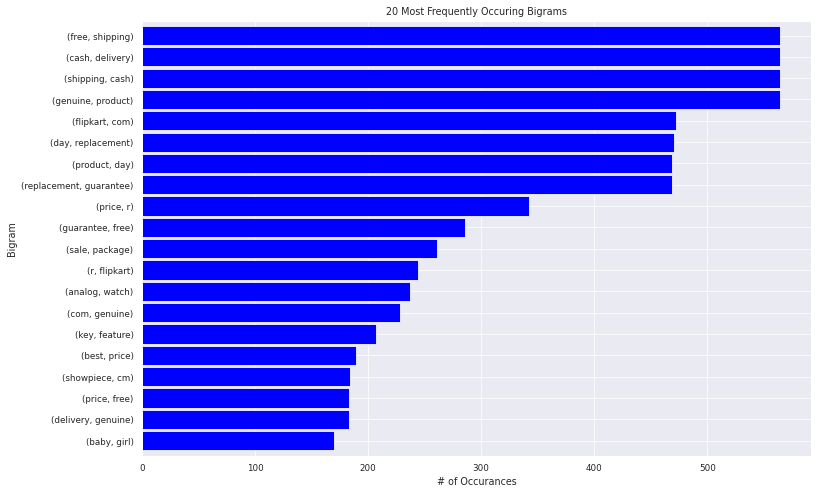

In [ ]:
description_bigrams_series.sort_values().plot.barh(color='blue', width=.9, figsize=(12, 8))
plt.title('20 Most Frequently Occuring Bigrams')
plt.ylabel('Bigram')
plt.xlabel('# of Occurances')

In [ ]:
description_bigrams_series

(free, shipping)            564
(cash, delivery)            564
(shipping, cash)            564
(genuine, product)          564
(flipkart, com)             472
(day, replacement)          471
(product, day)              469
(replacement, guarantee)    469
(price, r)                  342
(guarantee, free)           286
(sale, package)             261
(r, flipkart)               244
(analog, watch)             237
(com, genuine)              228
(key, feature)              207
(best, price)               189
(showpiece, cm)             184
(delivery, genuine)         183
(price, free)               183
(baby, girl)                170
dtype: int64

### **Word2vec**

Each word's **TF-IDF** relevance is a normalized data format that also adds up to one. ... The main difference is that **Word2vec** produces one vector per word, whereas BoW produces one number (a wordcount). Word2vec is great for digging into documents and identifying content and subsets of content.

In [ ]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [ ]:
sentences = text_data['description_final_1']
sentences.sample(5)

268    ['buy', 'mom', 'wheel', 'pizza', 'cutter', 'on...
897    ['nkp', 'cotton', 'hand', 'towel', 'hand', 'to...
920    ['buy', 'baby', 'bucket', 'cartoon', 'single',...
729    ['key', 'feature', 'vrct', 'inch', 'green', 'r...
669    ['buy', 'trader', 'cotton', 'bath', 'towel', '...
Name: description_final_1, dtype: object

In [ ]:
from gensim.models import word2vec
model = Word2Vec.Word2Vec(sentences, size=300, window=20, min_count=2)
model.corpus_count

NameError: ignored

In [ ]:
vocab = model.wv.vocab
list(vocab)[:5]

['[', "'", 'k', 'e', 'y']

In [ ]:
from gensim.models import Word2Vec

# On entraîne le modèle
X= text_data['description_final_1']
sentance = [list(tokenize(s, deacc=True, lower=True)) for s in X]
model = Word2Vec(sentences, min_count=1, size=10)
print('model:',model)
print('')

# Vocabulaire
words = list(model.wv.vocab)
print('words:',words)
print('')

print(model)

model: Word2Vec(vocab=31, size=10, alpha=0.025)

words: ['[', "'", 'k', 'e', 'y', ',', ' ', 'f', 'a', 't', 'u', 'r', 'l', 'g', 'n', 'c', 'p', 'o', 's', 'm', 'i', 'b', 'd', 'h', 'q', 'v', 'w', 'x', ']', 'z', 'j']

Word2Vec(vocab=31, size=10, alpha=0.025)


In [ ]:
from gensim.models import Word2Vec
from gensim.utils import tokenize

X= text_data['description_final_1']
sentance = [list(tokenize(s, deacc=True, lower=True)) for s in X]
print(sentance[0])
model = Word2Vec(sentance, min_count=1,)
model.corpus_count

['key', 'feature', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'floral', 'curtain', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'height', 'pack', 'price', 'curtain', 'enhances', 'look', 'interior', 'curtain', 'made', 'high', 'quality', 'polyester', 'fabric', 'feature', 'eyelet', 'style', 'stitch', 'metal', 'ring', 'make', 'room', 'environment', 'curtain', 'ant', 'wrinkle', 'anti', 'shrinkage', 'elegant', 'give', 'home', 'bright', 'appeal', 'design', 'attention', 'sure', 'heart', 'contemporary', 'eyelet', 'curtain', 'slide', 'smoothly', 'draw', 'apart', 'first', 'thing', 'morning', 'welcome', 'bright', 'sun', 'ray', 'want', 'wish', 'good', 'morning', 'whole', 'world', 'draw', 'evening', 'create', 'special', 'moment', 'beauty', 'given', 'soothing', 'print', 'bring', 'home', 'elegant', 'curtain', 'light', 'room', 'get', 'right', 'amount', 'sunlight', 'specification', 'elegance', 'polyester', 'multicolor', 'abstract', 

1050

In [ ]:
model

In [ ]:
def get_vect(word, model):
    try:
        return model.wv[word]
    except KeyError:
        return np.zeros((model.vector_size,))

def sum_vectors(phrase, model):
    return sum(get_vect(w, model) for w in phrase)

def word2vec_features(X, model):
    feats = np.vstack([sum_vectors(p, model) for p in X])
    return feats


X_emb_DF = word2vec_features(text_data['description_final_1'].copy(), model)

X_emb_DF.shape

(1050, 100)

In [ ]:
model_w2v = km_model.fit(X_emb_DF)

In [ ]:
labels_model_w2v = pd.DataFrame(model_w2v.labels_, columns=['model_w2v'])

In [ ]:
tot_data_label = pd.concat([tot_data_label,labels_model_w2v], axis=1)
tot_data_label.head()

NameError: ignored

In [ ]:
tot_data_label['model_w2v'].unique()

array([0], dtype=int32)

In [ ]:
ARI_lda = adjusted_rand_score( tot_data_label['label_category'], tot_data_label['lda_tfidf'])
ARI_lda

0.22962618873346055

In [ ]:
ARI_lda= pd.DataFrame({'columns':['lda'], 'ARI':[ARI_lda]})
ARI= ARI.append(ARI_lda, ignore_index=True)
ARI

columns       ARI
0         KM_tfidf_unigram  0.116624
1          KM_tfidf_bigram  0.116624
2  KM_tf_vectorize_unigram  0.116624
3   KM_tf_vectorize_bigram  0.116624
4                      lda  0.229626